# **DATA AUDIT**

Goal: list shapes, columns, dtypes, and basic null rates so we know what we can build—then we’ll design the exact feature set.

In [1]:
!pip install nfl_data_py
!pip install pandas
!pip install matplotlib
!pip install dotenv

In [2]:
# --- Environment setup (Colab-friendly) ---
import importlib
import os
import sys
from pathlib import Path

def _in_colab() -> bool:
    """Detect if we are running inside Google Colab."""
    try:
        import google.colab  # noqa: F401
        return True
    except ImportError:
        return False

if _in_colab():
    from google.colab import drive  # type: ignore
    if not os.path.exists('/content/drive/MyDrive'):
        drive.mount('/content/drive')

def _ensure_packages(specs):
    import subprocess
    for pkg, module in specs:
        target = module or pkg
        if importlib.util.find_spec(target) is None:
            subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg])

_ensure_packages([
    ('nfl_data_py', None),
    ('pandas', None),
    ('matplotlib', None),
    ('python-dotenv', 'dotenv'),
    ('pyarrow', None),
    ('scikit-learn', 'sklearn'),
])

BASE = Path('/content/drive/MyDrive/nfl-win-transformer') if _in_colab() else Path(os.getenv('NFL_PROJ_DIR', Path.cwd()))
SRC = BASE / 'src' / 'pipelines'
RAW = BASE / 'data' / 'raw'
INTM = BASE / 'data' / 'interim'
PROC = BASE / 'data' / 'processed'
for folder in (RAW, INTM, PROC):
    folder.mkdir(parents=True, exist_ok=True)

if str(SRC) not in sys.path:
    sys.path.append(str(SRC))

print(f"BASE directory: {BASE}")


Mounted at /content/drive
BASE directory: /content/drive/MyDrive/nfl-win-transformer


In [ ]:
# ---- setup
# pip install nfl_data_py pandas numpy
import pandas as pd
import numpy as np
import nfl_data_py as nfl

YEARS = list(range(2018, 2025))   # adjust as you like

def peek(df, name, n=5):
    print(f"\n=== {name} ===")
    print(df.shape)
    print(df.head(n))
    # dtypes & nulls
    dd = pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'null_frac': df.isna().mean().round(3)
    }).sort_index()
    print(dd.head(20))  # first 20; widen as needed

# ---- catalog: what columns exist?
print("PBP columns (sample):", nfl.see_pbp_cols()[:25])
print("WEEKLY columns (sample):", nfl.see_weekly_cols()[:25])

# ---- core tables
sch = nfl.import_schedules(YEARS)
peek(sch, "schedules")

# play-by-play (can be large; consider one season first)
pbp = nfl.import_pbp_data([2024], columns=None, downcast=True)
peek(pbp, "pbp_2024")

# weekly player/team stats (aggregate to team-week later)
weekly = nfl.import_weekly_data(YEARS, columns=None, downcast=True)
peek(weekly, "weekly")

# optional: depth charts, injuries, officials, team descriptors
depth = nfl.import_depth_charts(YEARS)
peek(depth, "depth_charts")

inj = nfl.import_injuries(YEARS)
peek(inj, "injuries")

teams = nfl.import_team_desc()
peek(teams, "team_desc")


PBP columns (sample): Index(['play_id', 'game_id', 'old_game_id', 'home_team', 'away_team',
       'season_type', 'week', 'posteam', 'posteam_type', 'defteam',
       'side_of_field', 'yardline_100', 'game_date',
       'quarter_seconds_remaining', 'half_seconds_remaining',
       'game_seconds_remaining', 'game_half', 'quarter_end', 'drive', 'sp',
       'qtr', 'down', 'goal_to_go', 'time', 'yrdln'],
      dtype='object')
WEEKLY columns (sample): Index(['player_id', 'player_name', 'player_display_name', 'position',
       'position_group', 'headshot_url', 'recent_team', 'season', 'week',
       'season_type', 'opponent_team', 'completions', 'attempts',
       'passing_yards', 'passing_tds', 'interceptions', 'sacks', 'sack_yards',
       'sack_fumbles', 'sack_fumbles_lost', 'passing_air_yards',
       'passing_yards_after_catch', 'passing_first_downs', 'passing_epa',
       'passing_2pt_conversions'],
      dtype='object')

=== schedules ===
(1942, 46)
              game_id  season gam

# **Cell 1 — Setup (mount + installs + paths)**

In [3]:
# --- Verify paths from setup cell ---
from pathlib import Path

try:
    BASE, RAW, INTM, PROC
except NameError as exc:
    raise RuntimeError('Run the setup cell before executing downstream sections.') from exc

print(f"RAW:  {RAW}")
print(f"INTM: {INTM}")
print(f"PROC: {PROC}")


RAW:  /content/drive/MyDrive/nfl-win-transformer/data/raw
INTM: /content/drive/MyDrive/nfl-win-transformer/data/interim
PROC: /content/drive/MyDrive/nfl-win-transformer/data/processed


In [4]:
# --- Ensure Section A helpers are available even if the module import fails ---
import sys, types

try:
    from section_a_modeling_game_winner import build_games_core, save_vocabs, load_vocabs
except ModuleNotFoundError:
    module_path = SRC / 'section_a_modeling_game_winner.py'
    if not module_path.exists():
        raise
    module = types.ModuleType('section_a_modeling_game_winner')
    exec(module_path.read_text(encoding='utf-8'), module.__dict__)
    sys.modules['section_a_modeling_game_winner'] = module
    build_games_core = module.build_games_core
    save_vocabs = module.save_vocabs
    load_vocabs = module.load_vocabs


# **Cell 2 — (Optional) Data audit quick peek**

In [5]:
DO_AUDIT = False  # flip to True if you want the audit prints

if DO_AUDIT:
    import nfl_data_py as nfl
    import pandas as pd

    YEARS = list(range(2018, 2025))
    sch = nfl.import_schedules(YEARS)
    print("schedules:", sch.shape, list(sch.columns)[:12])
    pbp = nfl.import_pbp_data([2024], columns=None, downcast=True)  # one season to keep it light
    print("pbp_2024:", pbp.shape, list(pbp.columns)[:12])
    weekly = nfl.import_weekly_data(YEARS, columns=None, downcast=True)
    print("weekly:", weekly.shape, list(weekly.columns)[:12])


# **Cell 3 — Section A (build games_core.parquet + vocabs.json)**

In [6]:
# === Cell 3 — Section A (build games_core.parquet + vocabs.json) with keyed score merge + PBP fallback ===
import nfl_data_py as nfl
import pandas as pd
import numpy as np
from section_a_modeling_game_winner import build_games_core, save_vocabs

# Years to include (adjust as you like)
YEARS = list(range(2018, 2026))

# 0) Save RAW schedules (immutable snapshot)
raw_sch_path = RAW / f'schedules_{YEARS[0]}_{YEARS[-1]-1}.parquet'
schedules = nfl.import_schedules(YEARS).copy()
schedules.to_parquet(raw_sch_path, index=False)

# 1) Build Section A core rows (this must contain game_id)
games_core, vocabs = build_games_core(schedules, tie_mode="drop")

# 2) Figure out where scores live in schedules (schema-robust)
def _pick(df, cand):
    for c in cand:
        if c in df.columns:
            return c
    return None

home_score_col = _pick(schedules, ['home_score','home_points'])
away_score_col = _pick(schedules, ['away_score','away_points'])

sched_scores = pd.DataFrame({'game_id': schedules['game_id']})
if home_score_col is not None:
    sched_scores['home_score'] = pd.to_numeric(schedules[home_score_col], errors='coerce')
else:
    sched_scores['home_score'] = np.nan
if away_score_col is not None:
    sched_scores['away_score'] = pd.to_numeric(schedules[away_score_col], errors='coerce')
else:
    sched_scores['away_score'] = np.nan

# 3) If schedules didn’t carry scores, derive from PBP as a fallback
need_pbp_fallback = not (sched_scores['home_score'].notna().any() and sched_scores['away_score'].notna().any())

if need_pbp_fallback:
    # Pull PBP for the same years and take the last score per game_id
    # (use columns present; prefer 'home_score'/'away_score' if available)
    pbp = nfl.import_pbp_data(YEARS)
    # pick score columns from pbp
    pbp_home_col = _pick(pbp, ['home_score','total_home_score'])
    pbp_away_col = _pick(pbp, ['away_score','total_away_score'])
    if pbp_home_col is None or pbp_away_col is None:
        # nothing we can do — leave NaN; downstream should tolerate
        print("[WARN] PBP fallback unavailable (no score columns found).")
    else:
        # last non-null per game
        pbp2 = pbp[['game_id', pbp_home_col, pbp_away_col]].copy()
        pbp2[pbp_home_col] = pd.to_numeric(pbp2[pbp_home_col], errors='coerce')
        pbp2[pbp_away_col] = pd.to_numeric(pbp2[pbp_away_col], errors='coerce')
        # keep last row per game_id (PBP is roughly play-ordered; we’ll still be safe)
        pbp_last = (pbp2.dropna(subset=['game_id'])
                         .groupby('game_id', as_index=False)
                         .agg({pbp_home_col:'last', pbp_away_col:'last'}))
        pbp_last = pbp_last.rename(columns={pbp_home_col:'home_score', pbp_away_col:'away_score'})
        # merge into sched_scores, only filling NaNs
        sched_scores = sched_scores.merge(pbp_last, on='game_id', how='left', suffixes=('','_pbp'))
        for c in ['home_score','away_score']:
            sched_scores[c] = sched_scores[c].where(sched_scores[c].notna(), sched_scores[f'{c}_pbp'])
        sched_scores.drop(columns=[c for c in ['home_score_pbp','away_score_pbp'] if c in sched_scores], inplace=True)

# 4) Merge scores into games_core by KEY (game_id), not by index
scores = sched_scores[['game_id','home_score','away_score']].copy()
scores['home_score'] = pd.to_numeric(scores['home_score'], errors='coerce').astype('float32')
scores['away_score'] = pd.to_numeric(scores['away_score'], errors='coerce').astype('float32')

games_core = games_core.merge(scores, on='game_id', how='left', validate='one_to_one')

# 5) Derived totals
games_core['margin'] = games_core['home_score'] - games_core['away_score']
games_core['total_points'] = games_core['home_score'] + games_core['away_score']

# 6) Persist INTERIM + PROCESSED + vocabs
inter_games = INTM / 'games_core.parquet'
proc_games  = PROC / 'games_core.parquet'
inter_voc   = INTM / 'vocabs.json'

games_core.to_parquet(inter_games, index=False)
games_core.to_parquet(proc_games, index=False)
save_vocabs(vocabs, inter_voc)

print("WROTE:", inter_games)
print("WROTE:", proc_games)
print("WROTE:", inter_voc)

# 7) Sanity: show per-season non-null score counts
def _count_nonnull(g):
    return (g['home_score'].notna() & g['away_score'].notna()).sum()

cc = (games_core.groupby('season')[['home_score','away_score']]
                .apply(lambda x: (x['home_score'].notna() & x['away_score'].notna()).sum()))
print("\n[SANITY] games_core rows:", games_core.shape)
print("[SANITY] non-null scores by season:")
print(cc.to_string())


[INFO] Built games_core: 2120 rows, 32 columns
INFO:section_a_modeling:Built games_core: 2120 rows, 32 columns
[INFO] Vocab sizes — teams: 34, QBs: 143, coaches: 84
INFO:section_a_modeling:Vocab sizes — teams: 34, QBs: 143, coaches: 84


WROTE: /content/drive/MyDrive/nfl-win-transformer/data/interim/games_core.parquet
WROTE: /content/drive/MyDrive/nfl-win-transformer/data/processed/games_core.parquet
WROTE: /content/drive/MyDrive/nfl-win-transformer/data/interim/vocabs.json

[SANITY] games_core rows: (2120, 36)
[SANITY] non-null scores by season:
season
2018    254
2019    255
2020    255
2021    271
2022    269
2023    272
2024    272
2025     33


# **Cell 4**

artifacts in one go:

team_week_features.parquet (expanded stats + directionality + shrinkage + win%)

injury_counts.parquet (OUT/DOUBTFUL by unit + totals)

rest_travel.parquet (rest days, short-week, bye_prev, time-zone travel flags)

qb_form.parquet (QB rolling EPA/dropback, sack%, INT%, YPA, 1D%)

qb_flags.parquet (starter change + QB OUT/DOUBTFUL for the week)

In [7]:
# =========================
# Cell 4 — Consolidated Feature Builders (Tempo/Pressure/Formation Enhancements)
# =========================
# Outputs under data/interim/:
#  - team_week_features.parquet
#  - injury_counts.parquet
#  - rest_travel.parquet
#  - qb_form.parquet
#  - qb_flags.parquet

import os, numpy as np, pandas as pd
from pathlib import Path
from typing import List, Dict, Tuple
import nfl_data_py as nfl

# -------------------------
# Paths / Config
# -------------------------
BASE = Path(os.getenv('NFL_PROJ_DIR', '/content/drive/MyDrive/nfl-win-transformer'))
DATA_INTERIM = (BASE / 'data' / 'interim'); DATA_INTERIM.mkdir(parents=True, exist_ok=True)
YEARS: List[int] = list(range(2018, 2026))  # 2018..2025

FN_TEAMWEEK = DATA_INTERIM / 'team_week_features.parquet'
FN_INJ      = DATA_INTERIM / 'injury_counts.parquet'
FN_REST     = DATA_INTERIM / 'rest_travel.parquet'
FN_QBF      = DATA_INTERIM / 'qb_form.parquet'
FN_QBFLAGS  = DATA_INTERIM / 'qb_flags.parquet'

EARLY_BOOTSTRAP = True   # fill wk<=3 rolling NaNs with seasonal priors (safe)

# -------------------------
# Team aliases & time zones
# -------------------------
TEAM_ALIAS = {'WFT':'WAS','WSH':'WAS','WAS':'WAS','OAK':'LV','RAI':'LV','LV':'LV',
              'SD':'LAC','SDG':'LAC','LAC':'LAC','SDC':'LAC','STL':'LAR','LA':'LAR','LAR':'LAR'}
def norm_team(t: str) -> str:
    if pd.isna(t):
        return t
    return TEAM_ALIAS.get(t.strip().upper(), t.strip().upper())

TZ_TEAM = {'BUF':0,'MIA':0,'NE':0,'NYJ':0,'BAL':0,'CIN':0,'CLE':0,'PIT':0,'IND':0,'JAX':0,'TB':0,'ATL':0,'CAR':0,'WAS':0,'PHI':0,'NYG':0,'DET':0,
           'CHI':-1,'GB':-1,'MIN':-1,'NO':-1,'DAL':-1,'HOU':-1,'TEN':-1,'KC':-1,
           'ARI':-2,'DEN':-2,
           'LAR':-3,'LAC':-3,'SF':-3,'SEA':-3,'LV':-3}

# -------------------------
# Common loaders
# -------------------------
def load_pbp_years(years: List[int]) -> pd.DataFrame:
    dfs = []
    for y in years:
        try:
            df_y = nfl.import_pbp_data([y])
        except Exception:
            df_y = nfl.import_pbp([y])
        df_y['season'] = y
        dfs.append(df_y)
    return pd.concat(dfs, ignore_index=True, sort=False)

def load_schedules_years(years: List[int]) -> pd.DataFrame:
    try:
        s = nfl.import_schedules(years)
    except Exception:
        s = nfl.import_schedules(range(min(years), max(years)+1))
    for c in ['home_team','away_team','game_type','season','week']:
        if c not in s.columns:
            raise ValueError(f"schedules missing column {c}")
    date_col = 'gameday' if 'gameday' in s.columns else ('game_date' if 'game_date' in s.columns else None)
    if date_col is None:
        if 'start_time' in s.columns:
            s['gameday'] = pd.to_datetime(s['start_time']).dt.date
            date_col = 'gameday'
        else:
            s['gameday'] = pd.NaT
            date_col = 'gameday'
    s['game_date'] = pd.to_datetime(s[date_col])
    s['home_team'] = s['home_team'].map(norm_team)
    s['away_team'] = s['away_team'].map(norm_team)
    return s

# -------------------------
# Helpers
# -------------------------
def pick_col(df: pd.DataFrame, candidates: List[str]):
    for c in candidates:
        if c in df.columns:
            return c
    return None

def safe_import_injuries(years: List[int]) -> pd.DataFrame:
    frames = []
    for y in years:
        try:
            frames.append(nfl.import_injuries([y]))
        except Exception as e:
            print(f"[injuries] skipping {y}: {type(e).__name__}")
            continue
    if frames:
        return pd.concat(frames, ignore_index=True, sort=False)
    return pd.DataFrame(columns=['season','week','team','position','status','player_name','gsis_id'])

# -------------------------
# A) Team-week features (expanded to include tempo/pressure/formation metrics)
# -------------------------
def base_play_filter(pbp: pd.DataFrame) -> pd.DataFrame:
    df = pbp.copy()
    for col, default in [
        ('qb_kneel',0), ('qb_spike',0), ('two_point_attempt',0),
        ('fumble',0), ('fumble_lost',0), ('interception',0),
        ('success',np.nan), ('wp',np.nan), ('score_differential',np.nan),
        ('play_type',np.nan), ('down',np.nan), ('yards_gained',0.0),
        ('air_yards',np.nan), ('sack',0), ('qb_hit',0), ('pressure',0),
        ('offense_formation','UNK'), ('motion',''), ('game_id',np.nan),
        ('play_id',np.nan), ('game_seconds_remaining',np.nan), ('drive',np.nan)
    ]:
        if col not in df.columns:
            df[col] = default

    df = df.sort_values(['game_id','play_id']).copy()

    m = df['play_type'].isin(['pass','run'])
    m &= (df['qb_kneel'].fillna(0)==0) & (df['qb_spike'].fillna(0)==0)
    m &= (df['two_point_attempt'].fillna(0)==0)
    cols = ['season','week','game_id','posteam','defteam','epa','play_type','down',
            'success','wp','score_differential','fumble','fumble_lost','interception',
            'yards_gained','air_yards','sack','qb_hit','pressure','offense_formation','motion',
            'game_seconds_remaining','drive']
    df = df.loc[m, cols].copy()

    df['is_pass'] = (df['play_type']=='pass').astype('int8')
    df['is_run']  = (df['play_type']=='run').astype('int8')
    df['is_d3']   = (df['down']==3).astype('int8')
    df['is_d3_pass'] = (df['is_pass'] & df['is_d3']).astype('int8')
    df['is_d3_run']  = (df['is_run']  & df['is_d3']).astype('int8')

    ay = df['air_yards'].fillna(-999)
    yg = df['yards_gained'].fillna(0)
    df['exp_pass'] = ((df['is_pass']==1) & ((yg>=20) | (ay>=20))).astype('int8')
    df['exp_run']  = ((df['is_run']==1)  &  (yg>=10)).astype('int8')

    succ = df['success'].astype(float).fillna(0.0)
    if df['wp'].notna().any():
        close = df['wp'].between(0.20,0.80).astype('int8')
        lead  = (df['wp']>=0.90).astype('int8')
    else:
        sd = df['score_differential'].fillna(0)
        close = (sd.abs()<=7).astype('int8'); lead = (sd>=14).astype('int8')
    trail = (df['score_differential'].fillna(0) <= -7).astype('int8')
    df['succ'] = succ
    df['succ_pass'] = succ * df['is_pass']
    df['succ_run'] = succ * df['is_run']
    df['succ_d3_pass']= succ * df['is_d3_pass']
    df['succ_d3_run']= succ * df['is_d3_run']
    df['close'] = close; df['lead'] = lead; df['trail'] = trail
    df['succ_close'] = succ * close; df['succ_lead'] = succ * lead; df['succ_trail'] = succ * trail

    df['epa_pass'] = df['epa'] * df['is_pass']
    df['epa_run']  = df['epa'] * df['is_run']

    df['fumble'] = df['fumble'].fillna(0).astype('int8')
    df['fumble_lost'] = df['fumble_lost'].fillna(0).astype('int8')
    df['interception'] = df['interception'].fillna(0).astype('int8')
    df['sack'] = df['sack'].fillna(0).astype('int8')
    df['qb_hit'] = df['qb_hit'].fillna(0).astype('int8')
    df['pressure'] = df['pressure'].fillna(0).astype('int8')
    df['pressure_events'] = df['sack'] + df['qb_hit'] + df['pressure']

    form = df['offense_formation'].astype(str).str.lower()
    df['has_motion'] = df['motion'].astype(str).str.strip().ne('').astype('int8')
    df['is_shotgun'] = form.str.contains('shotgun', na=False).astype('int8')
    df['is_under_center'] = form.str.contains('under center', na=False).astype('int8')

    df['sec_prev'] = df.groupby('game_id')['game_seconds_remaining'].shift(1)
    df['play_sec'] = (df['sec_prev'] - df['game_seconds_remaining']).clip(lower=0).fillna(0.0)

    return df

def aggregate_side(df: pd.DataFrame, team_col: str) -> pd.DataFrame:
    keys = ['season','week',team_col]
    g = df.groupby(keys, sort=False)
    agg = g.agg(
        n_off_plays=('epa','size'),
        n_pass=('is_pass','sum'), n_run=('is_run','sum'),
        pass_epa_sum=('epa_pass','sum'), run_epa_sum=('epa_run','sum'),
        succ_all=('succ','sum'), pass_succ=('succ_pass','sum'), run_succ=('succ_run','sum'),
        d3p_succ=('succ_d3_pass','sum'), d3p_att=('is_d3_pass','sum'),
        d3r_succ=('succ_d3_run','sum'), d3r_att=('is_d3_run','sum'),
        close_succ=('succ_close','sum'), close_cnt=('close','sum'),
        lead_succ=('succ_lead','sum'), lead_cnt=('lead','sum'),
        trail_succ=('succ_trail','sum'), trail_cnt=('trail','sum'),
        fum=('fumble','sum'), fum_lost=('fumble_lost','sum'), ints=('interception','sum'),
        exp_pass_cnt=('exp_pass','sum'), exp_run_cnt=('exp_run','sum'),
        sacks=('sack','sum'), qb_hits=('qb_hit','sum'), pressures=('pressure','sum'),
        motion_cnt=('has_motion','sum'), shotgun_cnt=('is_shotgun','sum'), under_center_cnt=('is_under_center','sum'),
        play_sec=('play_sec','sum'), drive_count=('drive','nunique')
    ).reset_index()

    with np.errstate(divide='ignore', invalid='ignore'):
        agg['pass_epa_pp'] = agg['pass_epa_sum'] / agg['n_pass'].replace(0,np.nan)
        agg['rush_epa_pp'] = agg['run_epa_sum'] / agg['n_run'].replace(0,np.nan)
        agg['off_sr'] = agg['succ_all'] / agg['n_off_plays'].replace(0,np.nan)
        agg['pass_sr'] = agg['pass_succ'] / agg['n_pass'].replace(0,np.nan)
        agg['rush_sr'] = agg['run_succ'] / agg['n_run'].replace(0,np.nan)
        agg['sr_3d_pass'] = agg['d3p_succ'] / agg['d3p_att'].replace(0,np.nan)
        agg['sr_3d_run'] = agg['d3r_succ'] / agg['d3r_att'].replace(0,np.nan)
        agg['sr_close'] = agg['close_succ'] / agg['close_cnt'].replace(0,np.nan)
        agg['sr_leadbig'] = agg['lead_succ'] / agg['lead_cnt'].replace(0,np.nan)
        agg['trailing_sr'] = agg['trail_succ'] / agg['trail_cnt'].replace(0,np.nan)
        agg['fum_rate'] = agg['fum'] / agg['n_off_plays'].replace(0,np.nan)
        agg['fum_lost_rate'] = agg['fum_lost'] / agg['n_off_plays'].replace(0,np.nan)
        agg['int_rate'] = agg['ints'] / agg['n_pass'].replace(0,np.nan)
        dropbacks = agg['n_pass'] + agg['sacks']
        agg['pressure_rate'] = (agg['sacks'] + agg['qb_hits'] + agg['pressures']) / dropbacks.replace(0,np.nan)
        agg['motion_rate'] = agg['motion_cnt'] / agg['n_off_plays'].replace(0,np.nan)
        agg['shotgun_rate'] = agg['shotgun_cnt'] / agg['n_off_plays'].replace(0,np.nan)
        agg['under_center_rate'] = agg['under_center_cnt'] / agg['n_off_plays'].replace(0,np.nan)
        agg['seconds_per_play'] = agg['play_sec'] / agg['n_off_plays'].replace(0,np.nan)
        agg['tempo_pace'] = (agg['n_off_plays'] / agg['play_sec'].replace(0,np.nan)) * 60.0
        agg['time_pos_eff'] = agg['play_sec'] / agg['drive_count'].replace(0,np.nan)
        agg['exp_pass_rate'] = agg['exp_pass_cnt'] / agg['n_pass'].replace(0,np.nan)
        agg['exp_run_rate'] = agg['exp_run_cnt'] / agg['n_run'].replace(0,np.nan)
        agg['exp_rate'] = (agg['exp_pass_cnt'] + agg['exp_run_cnt']) / agg['n_off_plays'].replace(0,np.nan)

    agg['pressure_rate'] = agg['pressure_rate'].astype(float)
    agg['motion_rate'] = agg['motion_rate'].astype(float)
    agg['shotgun_rate'] = agg['shotgun_rate'].astype(float)
    agg['under_center_rate'] = agg['under_center_rate'].astype(float)
    agg['seconds_per_play'] = agg['seconds_per_play'].replace([np.inf,-np.inf], np.nan).astype(float)
    agg['tempo_pace'] = agg['tempo_pace'].replace([np.inf,-np.inf], np.nan).astype(float)
    agg['time_pos_eff'] = agg['time_pos_eff'].astype(float)
    agg['trailing_sr'] = agg['trailing_sr'].astype(float)

    sd_overall = df.groupby(keys)['epa'].std().rename('epa_sd').reset_index()
    sd_pass = df.loc[df['is_pass']==1].groupby(keys)['epa'].std().rename('pass_epa_sd').reset_index()
    sd_run  = df.loc[df['is_run']==1].groupby(keys)['epa'].std().rename('rush_epa_sd').reset_index()
    agg = agg.merge(sd_overall, on=keys, how='left').merge(sd_pass, on=keys, how='left').merge(sd_run, on=keys, how='left')
    agg = agg.rename(columns={team_col:'team'})
    return agg

def aggregate_special_teams(pbp: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    st = pbp.copy()
    if 'play_type' not in st.columns:
        return pd.DataFrame(), pd.DataFrame()
    m = st['play_type'].isin(['punt','kickoff','field_goal','extra_point'])
    st = st.loc[m, ['season','week','posteam','defteam','epa']].copy()
    off = (st.groupby(['season','week','posteam'], as_index=False)
              .agg(st_epa_mean=('epa','mean'), st_epa_sd=('epa','std'), st_n=('epa','size'))
              .rename(columns={'posteam':'team'}))
    deff = (st.groupby(['season','week','defteam'], as_index=False)
               .agg(def_st_epa_mean=('epa','mean'), def_st_epa_sd=('epa','std'), def_st_n=('epa','size'))
               .rename(columns={'defteam':'team'}))
    return off, deff

def aggregate_kicker_4055(pbp: pd.DataFrame) -> pd.DataFrame:
    if 'play_type' not in pbp.columns:
        return pd.DataFrame()
    fg = pbp.loc[pbp['play_type']=='field_goal', ['season','week','posteam','field_goal_result','kick_distance']].copy()
    for c in ['field_goal_result','kick_distance']:
        if c not in fg.columns:
            fg[c] = np.nan
    fg['is_4055'] = (pd.to_numeric(fg['kick_distance'], errors='coerce').between(40,55)).astype('int8')
    res = (fg['field_goal_result'].astype(str).str.lower()=='made').astype('int8')
    fg['made_4055'] = (fg['is_4055'] & res).astype('int8')
    agg = (fg.groupby(['season','week','posteam'], as_index=False)
             .agg(k_fg4055_att=('is_4055','sum'),
                  k_fg4055_made=('made_4055','sum'))
             .rename(columns={'posteam':'team'}))
    with np.errstate(divide='ignore', invalid='ignore'):
        agg['k_fg4055_rate'] = agg['k_fg4055_made'] / agg['k_fg4055_att'].replace(0,np.nan)
    return agg

def slope_last_k(v: pd.Series, k: int=5) -> float:
    vv = v.dropna()
    if len(vv) < 3:
        return np.nan
    w = vv.iloc[-k:] if len(vv)>=k else vv
    x = np.arange(len(w), dtype=float)
    try:
        return np.polyfit(x, w.values.astype(float), 1)[0]
    except Exception:
        return np.nan

def add_shift_roll_trend(df_tw: pd.DataFrame, stat_cols: List[str]) -> pd.DataFrame:
    df = df_tw.sort_values(['team','season','week']).copy()
    def _do(g):
        g = g.copy()
        g[stat_cols] = g[stat_cols].shift(1)  # leakage-safe
        for c in stat_cols:
            g[f'{c}_l4']    = g[c].rolling(4, min_periods=2).mean()
            g[f'{c}_l8']    = g[c].rolling(8, min_periods=3).mean()
            g[f'{c}_trend'] = g[f'{c}_l4'] - g[f'{c}_l8']
            g[f'{c}_slope5']= g[c].rolling(8, min_periods=3).apply(lambda s: slope_last_k(s, 5), raw=False)
        return g
    return df.groupby('team', group_keys=False).apply(_do)

def eb_shrink_rate(x, n, r0, k):
    if pd.isna(n) or n<=0 or pd.isna(x) or pd.isna(r0):
        return np.nan
    return (x + k*r0) / (n + k)

def add_shrinkage(df_tw: pd.DataFrame) -> pd.DataFrame:
    df = df_tw.copy()
    if 'k_fg4055_att' not in df:
        df['k_fg4055_att'] = np.nan
    if 'k_fg4055_rate' not in df:
        df['k_fg4055_rate'] = np.nan

    seas_prior = (df.groupby('season')
                    .agg(sr3p=('sr_3d_pass','mean'),
                         sr3r=('sr_3d_run','mean'),
                         intr=('int_rate','mean'),
                         fumr=('fum_rate','mean'),
                         kfg=('k_fg4055_rate','mean'),
                         press=('pressure_rate_allowed','mean'))
                    .reset_index())
    df = df.merge(seas_prior, on='season', how='left')

    df['n_3d_pass'] = df['d3p_att']
    df['n_3d_run'] = df['d3r_att']
    k3, kint, kfum, kkick, kpress = 100.0, 300.0, 200.0, 10.0, 150.0

    x_sr3p = df['sr_3d_pass']*df['n_3d_pass']
    x_sr3r = df['sr_3d_run']*df['n_3d_run']
    x_intr = df['int_rate']*df['n_pass']
    x_fumr = df['fum_rate']*df['n_off_plays']
    x_kick = df['k_fg4055_rate']*df['k_fg4055_att']
    x_press = df['pressure_rate_allowed']*(df['n_pass'] + df['sacks'])

    df['sr_3d_pass_shr'] = [eb_shrink_rate(x,n,r0,k3)   for x,n,r0 in zip(x_sr3p, df['n_3d_pass'], df['sr3p'])]
    df['sr_3d_run_shr']  = [eb_shrink_rate(x,n,r0,k3)   for x,n,r0 in zip(x_sr3r, df['n_3d_run'],  df['sr3r'])]
    df['int_rate_shr']   = [eb_shrink_rate(x,n,r0,kint) for x,n,r0 in zip(x_intr, df['n_pass'],    df['intr'])]
    df['fum_rate_shr']   = [eb_shrink_rate(x,n,r0,kfum) for x,n,r0 in zip(x_fumr, df['n_off_plays'], df['fumr'])]
    df['k_fg4055_rate_shr'] = [eb_shrink_rate(x,n,r0,kkick) for x,n,r0 in zip(x_kick, df['k_fg4055_att'], df['kfg'])]
    df['pressure_rate_allowed_shr'] = [eb_shrink_rate(x,n,r0,kpress) for x,n,r0 in zip(x_press, df['n_pass'] + df['sacks'], df['press'])]
    df['fum_luck'] = df['fum_lost_rate'] - 0.5*df['fum_rate']
    return df

def add_winpct_features(sched: pd.DataFrame) -> pd.DataFrame:
    mask_reg = (sched['game_type']=='REG') & sched['home_team'].notna() & sched['away_team'].notna()
    s = sched.loc[mask_reg, ['season','week','home_team','away_team','home_score','away_score']].copy()
    long = []
    for _, r in s.iterrows():
        long.append({'season':r.season,'week':r.week,'team':r.home_team,'opp':r.away_team,'win':int((r.home_score or 0) > (r.away_score or 0))})
        long.append({'season':r.season,'week':r.week,'team':r.away_team,'opp':r.home_team,'win':int((r.away_score or 0) > (r.home_score or 0))})
    tw = pd.DataFrame(long).sort_values(['team','season','week'])
    def _wins(g):
        g = g.copy()
        g['gp'] = np.arange(len(g))+1
        g['wins_to_date']  = g['win'].shift(1).cumsum()
        g['games_to_date'] = g['gp'] - 1
        g['win_pct_to_date'] = g['wins_to_date'] / g['games_to_date'].replace(0,np.nan)
        g['win_pct_l4'] = g['win'].shift(1).rolling(4,min_periods=2).mean()
        g['win_pct_l8'] = g['win'].shift(1).rolling(8,min_periods=3).mean()
        g['win_pct_trend'] = g['win_pct_l4'] - g['win_pct_l8']
        return g
    tw = tw.groupby('team', group_keys=False).apply(_wins)
    return tw[['season','week','team','win_pct_to_date','win_pct_l4','win_pct_l8','win_pct_trend']]

def bootstrap_early(tw: pd.DataFrame, base_cols: List[str]) -> pd.DataFrame:
    out = tw.copy()
    m = out['week'] <= 3
    for c in base_cols:
        l4, l8, tr, sl = f'{c}_l4', f'{c}_l8', f'{c}_trend', f'{c}_slope5'
        if l4 in out and l8 in out:
            prior = out.groupby('season')[c].transform('mean')
            out.loc[m, l4] = out.loc[m, l4].fillna(prior[m])
            out.loc[m, l8] = out.loc[m, l8].fillna(prior[m])
        if tr in out: out.loc[m, tr] = out.loc[m, tr].fillna(0.0)
        if sl in out: out.loc[m, sl] = out.loc[m, sl].fillna(0.0)
    return out

def build_team_week_features(years: List[int]) -> pd.DataFrame:
    pbp = load_pbp_years(years)
    pbp_f = base_play_filter(pbp)

    off = aggregate_side(pbp_f, 'posteam')
    off.rename(columns={'pressure_rate': 'pressure_rate_allowed'}, inplace=True)

    dfn = aggregate_side(pbp_f, 'defteam')
    dfn = dfn.add_prefix('def_')
    dfn = dfn.rename(columns={'def_season': 'season','def_week': 'week','def_team': 'team',
                              'def_pressure_rate':'def_pressure_rate',
                              'def_motion_rate':'def_motion_rate_allowed',
                              'def_shotgun_rate':'def_shotgun_rate_allowed',
                              'def_under_center_rate':'def_under_center_rate_allowed',
                              'def_seconds_per_play':'def_seconds_per_play_allowed',
                              'def_tempo_pace':'def_tempo_pace_allowed',
                              'def_time_pos_eff':'def_time_pos_eff_allowed',
                              'def_trailing_sr':'def_trailing_sr_allowed'})

    tw = off.merge(dfn, on=['season','week','team'], how='outer', validate='one_to_one')

    st_off, st_def = aggregate_special_teams(pbp)
    if not st_off.empty: tw = tw.merge(st_off, on=['season','week','team'], how='left')
    if not st_def.empty: tw = tw.merge(st_def, on=['season','week','team'], how='left')
    kick = aggregate_kicker_4055(pbp)
    if not kick.empty: tw = tw.merge(kick, on=['season','week','team'], how='left')

    tw = add_shrinkage(tw)

    if 'tempo_pace' in tw.columns:
        tempo_avg = tw.groupby(['season','week'])['tempo_pace'].transform('mean')
        tw['tempo_vs_avg'] = tw['tempo_pace'] - tempo_avg
    if 'def_tempo_pace_allowed' in tw.columns:
        tempo_def_avg = tw.groupby(['season','week'])['def_tempo_pace_allowed'].transform('mean')
        tw['def_tempo_vs_avg_allowed'] = tw['def_tempo_pace_allowed'] - tempo_def_avg

    stat_cols = [
        'pass_epa_pp','rush_epa_pp','off_sr','pass_sr','rush_sr',
        'sr_3d_pass','sr_3d_run','sr_3d_pass_shr','sr_3d_run_shr',
        'sr_close','sr_leadbig','epa_sd','pass_epa_sd','rush_epa_sd',
        'exp_pass_rate','exp_run_rate','exp_rate','fum_rate','fum_lost_rate','fum_luck',
        'int_rate','int_rate_shr','fum_rate_shr','k_fg4055_rate','k_fg4055_rate_shr',
        'pressure_rate_allowed','pressure_rate_allowed_shr','motion_rate','shotgun_rate','under_center_rate',
        'seconds_per_play','tempo_pace','tempo_vs_avg','time_pos_eff','trailing_sr'
    ]
    def_cols = [
        'def_pass_epa_pp','def_rush_epa_pp','def_off_sr','def_pass_sr','def_rush_sr',
        'def_sr_3d_pass','def_sr_3d_run','def_epa_sd','def_pass_epa_sd','def_rush_epa_sd',
        'def_exp_pass_rate','def_exp_run_rate','def_exp_rate','def_pressure_rate',
        'def_motion_rate_allowed','def_shotgun_rate_allowed','def_under_center_rate_allowed',
        'def_seconds_per_play_allowed','def_tempo_pace_allowed','def_tempo_vs_avg_allowed','def_time_pos_eff_allowed','def_trailing_sr_allowed',
        'def_st_epa_mean','def_st_epa_sd'
    ]
    for c in stat_cols + def_cols:
        if c not in tw.columns:
            tw[c] = np.nan

    tw = add_shift_roll_trend(tw, stat_cols + def_cols)
    tw = tw.sort_values(['team','season','week'])
    tw['fum_luck_l8'] = tw.groupby('team')['fum_luck'].shift(1).rolling(8, min_periods=3).mean()

    if EARLY_BOOTSTRAP:
        tw = bootstrap_early(tw, base_cols=stat_cols + def_cols)

    sched = load_schedules_years(years)
    winp = add_winpct_features(sched)
    tw = tw.merge(winp, on=['season','week','team'], how='left')

    tw.to_parquet(FN_TEAMWEEK, index=False)
    print(f"[Section B] team_week_features → {FN_TEAMWEEK} shape={tw.shape}")
    return tw

# -------------------------
# B) Injuries
# OUT/DOUBTFUL counts by unit (schema-robust)
# -------------------------
UNIT_MAP = {'QB':'QB','OL':'OL','C':'OL','G':'OL','T':'OL','OG':'OL','OT':'OL','OC':'OL',
            'WR':'WR_TE','TE':'WR_TE','RB':'RB','FB':'RB',
            'DL':'DL','DE':'DL','DT':'DL','NT':'DL','EDGE':'DL',
            'LB':'LB','ILB':'LB','OLB':'LB',
            'DB':'DB','CB':'DB','S':'DB','SS':'DB','FS':'DB',
            'K':'K_ST','P':'K_ST','LS':'K_ST','ST':'K_ST'}
def pos_to_unit(p: str) -> str:
    if pd.isna(p): return 'OTHER'
    return UNIT_MAP.get(p.strip().upper(), 'OTHER')

def build_injury_counts(years: List[int]) -> pd.DataFrame:
    inj = safe_import_injuries(years)
    if inj.empty:
        inj_w = pd.DataFrame(columns=['season','week','team'])
        inj_w.to_parquet(FN_INJ, index=False)
        print(f"[Section B2] injury_counts → {FN_INJ} (EMPTY; no seasons available)")
        return inj_w

    # Map schema diffs
    season_col = pick_col(inj, ['season','year'])
    week_col   = pick_col(inj, ['week'])
    team_col   = pick_col(inj, ['team','team_abbr','club_code'])
    pos_col    = pick_col(inj, ['position','pos','gsis_pos'])
    status_col = pick_col(inj, ['status','injury_status','game_status'])

    if season_col is None or week_col is None or team_col is None:
        print("[injury_counts] missing (season/week/team) keys; returning empty.")
        inj_w = pd.DataFrame(columns=['season','week','team'])
        inj_w.to_parquet(FN_INJ, index=False)
        return inj_w

    cols = [season_col, week_col, team_col]
    if pos_col:    cols.append(pos_col)
    if status_col: cols.append(status_col)
    inj = inj[cols].copy()

    inj.rename(columns={
        season_col:'season', week_col:'week', team_col:'team',
        **({pos_col:'position'} if pos_col else {}),
        **({status_col:'status'} if status_col else {})
    }, inplace=True)

    inj['team'] = inj['team'].map(norm_team)

    if 'status' not in inj.columns:
        inj_w = (inj[['season','week','team']].drop_duplicates().assign(out_doubtful_total=0))
        inj_w.to_parquet(FN_INJ, index=False)
        print("[injury_counts] no status column found; wrote zeros for out_doubtful_total.")
        return inj_w

    inj['unit'] = inj.get('position', 'OTHER')
    inj['unit'] = inj['unit'].astype(str).map(pos_to_unit)
    inj['status_u'] = inj['status'].astype(str).str.upper()
    inj['is_out'] = inj['status_u'].isin(['OUT','DOUBTFUL'])

    grp = (inj.groupby(['season','week','team','unit'], as_index=False)['is_out'].sum())
    inj_w = grp.pivot(index=['season','week','team'], columns='unit', values='is_out').fillna(0).reset_index()
    inj_w.columns = ['season','week','team'] + [f'out_doubtful_{c.lower()}' for c in inj_w.columns[3:]]
    inj_w['out_doubtful_total'] = inj_w.filter(like='out_doubtful_').sum(axis=1)

    inj_w.to_parquet(FN_INJ, index=False)
    print(f"[Section B2] injury_counts → {FN_INJ} shape={inj_w.shape}")
    return inj_w

# -------------------------
# C) Rest / Short week / Travel flags
# -------------------------
def build_rest_travel(years: List[int]) -> pd.DataFrame:
    s = load_schedules_years(years)
    s = s[s['game_type']=='REG'].copy()
    rows = []
    for _, r in s.iterrows():
        rows.append({'season':r.season,'week':r.week,'team':r.home_team,'opp':r.away_team,'date':r.game_date,'is_home':1,'site_tz':TZ_TEAM.get(r.home_team,0)})
        rows.append({'season':r.season,'week':r.week,'team':r.away_team,'opp':r.home_team,'date':r.game_date,'is_home':0,'site_tz':TZ_TEAM.get(r.home_team,0)})
    df = pd.DataFrame(rows).sort_values(['team','season','date']).reset_index(drop=True)
    df['team_tz'] = df['team'].map(TZ_TEAM).fillna(0).astype(int)
    df['rest_days'] = df.groupby('team')['date'].diff().dt.days
    df['short_week'] = (df['rest_days'] <= 4).astype('int8')
    df['bye_prev']   = (df['rest_days'] >= 13).astype('int8')
    df['tz_travel']  = (df['site_tz'] - df['team_tz']).astype(int)
    df['east_travel'] = (df['tz_travel'] > 0).astype('int8')
    df['west_travel'] = (df['tz_travel'] < 0).astype('int8')
    df['is_road'] = (df['is_home']==0).astype('int8')
    keep = df.sort_values(['team','season','week','date']).drop_duplicates(['team','season','week'], keep='last')
    out = keep[['season','week','team','rest_days','short_week','bye_prev','tz_travel','east_travel','west_travel','is_road']].copy()
    out.to_parquet(FN_REST, index=False)
    print(f"[Section B3] rest_travel → {FN_REST} shape={out.shape}")
    return out

# -------------------------
# D) QB Form (rolling) + E) QB flags (starter change + injury)
# -------------------------
def build_qb_form_and_flags(years: List[int]) -> (pd.DataFrame, pd.DataFrame):
    pbp = load_pbp_years(years)
    for c, default in [('qb_dropback',np.nan), ('passer_player_id',np.nan), ('passer_player_name',np.nan),
                       ('sack',0), ('interception',0), ('yards_gained',np.nan), ('first_down',0),
                       ('posteam',np.nan), ('defteam',np.nan), ('play_type',np.nan), ('epa',np.nan)]:
        if c not in pbp.columns: pbp[c] = default
    if pbp['qb_dropback'].notna().any():
        db_mask = pbp['qb_dropback'].astype('float').fillna(0) > 0
    else:
        db_mask = (pbp['play_type']=='pass') | (pbp['sack'].fillna(0)==1)
    qbdf = pbp.loc[db_mask, ['season','week','posteam','passer_player_id','passer_player_name',
                             'epa','sack','interception','yards_gained','first_down','play_type']].copy()
    qbdf['pass_att'] = (qbdf['play_type']=='pass').astype('int8')
    qbdf['sack'] = qbdf['sack'].fillna(0).astype('int8')
    qbdf['int']  = qbdf['interception'].fillna(0).astype('int8')
    qbdf['yds']  = qbdf['yards_gained'].fillna(0).astype('float32')
    qbdf['fd']   = qbdf['first_down'].fillna(0).astype('int8')
    qbdf['db'] = qbdf['pass_att'] + qbdf['sack']

    start = (qbdf.groupby(['season','week','posteam','passer_player_id','passer_player_name'], as_index=False)
                  .agg(db=('db','sum')))
    start['rank'] = start.groupby(['season','week','posteam'])['db'].rank(ascending=False, method='first')
    starters = start.loc[start['rank']==1, ['season','week','posteam','passer_player_id','passer_player_name','db']].rename(
        columns={'posteam':'team','passer_player_id':'qb_id','passer_player_name':'qb_name','db':'qb_db_week'}
    )

    qbstats = (qbdf.groupby(['season','week','posteam','passer_player_id','passer_player_name'], as_index=False)
                    .agg(db=('db','sum'), pa=('pass_att','sum'), sacks=('sack','sum'), ints=('int','sum'),
                         yds=('yds','sum'), fds=('fd','sum'), epa_sum=('epa','sum')))
    qbstats['epa_per_db'] = qbstats['epa_sum'] / qbstats['db'].replace(0,np.nan)
    qbstats['sack_rate']  = qbstats['sacks']   / qbstats['db'].replace(0,np.nan)
    qbstats['int_rate']   = qbstats['ints']    / qbstats['pa'].replace(0,np.nan)
    qbstats['ypa']        = qbstats['yds']     / qbstats['pa'].replace(0,np.nan)
    qbstats['fd_rate']    = qbstats['fds']     / qbstats['pa'].replace(0,np.nan)
    qbstats = qbstats.rename(columns={'posteam':'team','passer_player_id':'qb_id','passer_player_name':'qb_name'})

    qbstats = qbstats.sort_values(['qb_id','season','week']).reset_index(drop=True)
    for c in ['epa_per_db','sack_rate','int_rate','ypa','fd_rate','db']:
        qbstats[c] = qbstats[c].astype(float)
    def _qb_roll(g):
        g = g.copy()
        cols = ['epa_per_db','sack_rate','int_rate','ypa','fd_rate']
        g[cols] = g[cols].shift(1)
        for c in cols:
            g[f'{c}_l4'] = g[c].rolling(4, min_periods=2).mean()
            g[f'{c}_l8'] = g[c].rolling(8, min_periods=3).mean()
            g[f'{c}_trend'] = g[f'{c}_l4'] - g[f'{c}_l8']
        return g
    qbstats = qbstats.groupby('qb_id', group_keys=False).apply(_qb_roll)

    qb_form = starters.merge(
        qbstats[['season','week','team','qb_id','epa_per_db_l4','epa_per_db_l8','epa_per_db_trend',
                 'sack_rate_l4','sack_rate_l8','sack_rate_trend',
                 'int_rate_l4','int_rate_l8','int_rate_trend',
                 'ypa_l4','ypa_l8','ypa_trend',
                 'fd_rate_l4','fd_rate_l8','fd_rate_trend']],
        on=['season','week','team','qb_id'], how='left'
    )
    qb_form.to_parquet(FN_QBF, index=False)
    print(f"[Section B4] qb_form → {FN_QBF} shape={qb_form.shape}")

    qb_flags = qb_form.sort_values(['team','season','week']).copy()
    qb_flags['qb_prev'] = qb_flags.groupby('team')['qb_id'].shift(1)
    qb_flags['qb_changed'] = (qb_flags['qb_id'] != qb_flags['qb_prev']).astype('int8')

    # QB OUT/DOUBTFUL this week from injuries (schema-robust)
    inj = safe_import_injuries(years)
    if inj.empty:
        qb_flags['qb_out_count'] = 0
        qb_flags['qb_is_out'] = 0
    else:
        season_col = pick_col(inj, ['season','year'])
        week_col   = pick_col(inj, ['week'])
        team_col   = pick_col(inj, ['team','team_abbr','club_code'])
        pos_col    = pick_col(inj, ['position','pos','gsis_pos'])
        status_col = pick_col(inj, ['status','injury_status','game_status'])

        if season_col and week_col and team_col and pos_col and status_col:
            inj = inj[[season_col, week_col, team_col, pos_col, status_col]].copy()
            inj.rename(columns={
                season_col:'season', week_col:'week', team_col:'team',
                pos_col:'position', status_col:'status'
            }, inplace=True)
            inj['team'] = inj['team'].map(norm_team)
            inj['pos_u'] = inj['position'].astype(str).str.upper()
            inj['status_u'] = inj['status'].astype(str).str.upper()
            inj_qb = inj[(inj['pos_u']=='QB') & (inj['status_u'].isin(['OUT','DOUBTFUL']))]

            qb_out = (inj_qb.groupby(['season','week','team'], as_index=False)
                            .agg(qb_out_count=('status_u','size')))
            qb_flags = qb_flags.merge(qb_out, on=['season','week','team'], how='left')
            qb_flags['qb_out_count'] = qb_flags['qb_out_count'].fillna(0).astype(int)
            qb_flags['qb_is_out'] = (qb_flags['qb_out_count'] > 0).astype('int8')
        else:
            qb_flags['qb_out_count'] = 0
            qb_flags['qb_is_out'] = 0

    qb_flags.to_parquet(FN_QBFLAGS, index=False)
    print(f"[Section B5] qb_flags → {FN_QBFLAGS} shape={qb_flags.shape}")
    return qb_form, qb_flags

# =========================
# RUN ALL SECTION B BUILDERS
# =========================
tw  = build_team_week_features(YEARS)
inj = build_injury_counts(YEARS)
rst = build_rest_travel(YEARS)
qbf, qbf_flags = build_qb_form_and_flags(YEARS)

print("\n[Section B] Done.",
      f"\n  team_week_features: {FN_TEAMWEEK}",
      f"\n  injury_counts     : {FN_INJ}",
      f"\n  rest_travel       : {FN_REST}",
      f"\n  qb_form           : {FN_QBF}",
      f"\n  qb_flags          : {FN_QBFLAGS}")


2018 done.
Downcasting floats.
2019 done.
Downcasting floats.
2020 done.
Downcasting floats.
2021 done.
Downcasting floats.
2022 done.
Downcasting floats.
2023 done.
Downcasting floats.
2024 done.
Downcasting floats.
2025 done.
Downcasting floats.


Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-3718562410.py:289: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g[f'{c}_l4']    = g[c].rolling(4, min_periods=2).mean()
/tmp/ipython-input-3718562410.py:290: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  g[f'{c}_l8']    = g[c].rolling(8, min_periods=3).mean()
/tmp/ipython-input-3718562410.py:291: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining a

[Section B] team_week_features → /content/drive/MyDrive/nfl-win-transformer/data/interim/team_week_features.parquet shape=(3950, 383)
[injuries] skipping 2025: HTTPError
[injury_counts] no status column found; wrote zeros for out_doubtful_total.
[Section B3] rest_travel → /content/drive/MyDrive/nfl-win-transformer/data/interim/rest_travel.parquet shape=(4254, 10)
2018 done.
Downcasting floats.
2019 done.
Downcasting floats.
2020 done.
Downcasting floats.
2021 done.
Downcasting floats.
2022 done.
Downcasting floats.
2023 done.
Downcasting floats.
2024 done.
Downcasting floats.
2025 done.
Downcasting floats.
[Section B4] qb_form → /content/drive/MyDrive/nfl-win-transformer/data/interim/qb_form.parquet shape=(3950, 21)
[injuries] skipping 2025: HTTPError
[Section B5] qb_flags → /content/drive/MyDrive/nfl-win-transformer/data/interim/qb_flags.parquet shape=(3950, 25)

[Section B] Done. 
  team_week_features: /content/drive/MyDrive/nfl-win-transformer/data/interim/team_week_features.parquet

# **Cell 5 (join → game_rows.parquet)**

In [8]:
# =========================
# Cell 5 — Final Game Rows (JOIN + GAME Features incl. Tempo/Pressure + Weather/Altitude)
# =========================
import os, numpy as np, pandas as pd
from pathlib import Path

# -------------------------
# Paths
# -------------------------
BASE = Path(os.getenv('NFL_PROJ_DIR', '/content/drive/MyDrive/nfl-win-transformer'))
DATA_INTERIM   = BASE / 'data' / 'interim'
DATA_PROCESSED = BASE / 'data' / 'processed'
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)

# Prefer processed → interim → raw locations for games_core
CANDIDATES = [
    DATA_PROCESSED / 'games_core.parquet',
    DATA_INTERIM   / 'games_core.parquet',
    BASE / 'data' / 'raw' / 'games_core.parquet',
]
games_core_path = next((p for p in CANDIDATES if p.exists()), None)
if games_core_path is None:
    raise FileNotFoundError('games_core.parquet not found.')
print(f"[C] using games_core: {games_core_path}")

# -------------------------
# Load sources
# -------------------------
# === Prefer INTERIM games_core that we just wrote ===
games_core_path = DATA_INTERIM / 'games_core.parquet'
if not games_core_path.exists():
    raise FileNotFoundError(f'{games_core_path} missing; re-run Cell 3.')

gc = pd.read_parquet(games_core_path)

# Hard sanity check: we expect historical seasons to have scores
assert gc[['home_score','away_score']].notna().any().any(), \
    "games_core has no final scores. Re-run Cell 3 fix so scores are merged by game_id."

tw   = pd.read_parquet(DATA_INTERIM / 'team_week_features.parquet')
inj  = pd.read_parquet(DATA_INTERIM / 'injury_counts.parquet')
rest = pd.read_parquet(DATA_INTERIM / 'rest_travel.parquet')
qbf  = pd.read_parquet(DATA_INTERIM / 'qb_form.parquet')
qbf2 = pd.read_parquet(DATA_INTERIM / 'qb_flags.parquet')  # may be "skinny" or "wide", we guard below

# Ensure keys exist
for df_chk, name in [(tw,'team_week_features'), (inj,'injury_counts'),
                     (rest,'rest_travel'), (qbf,'qb_form'), (qbf2,'qb_flags')]:
    for c in ['season','week','team']:
        if c not in df_chk.columns:
            raise ValueError(f"{name} missing key column '{c}'")

# -------------------------
# Helpers
# -------------------------
def _dedupe_team_week(df: pd.DataFrame, name: str) -> pd.DataFrame:
    """Keep last record per (season, week, team)."""
    cols = ['season','week','team']
    if df.duplicated(cols).any():
        # Keep last occurrence deterministically
        df = df.sort_values(cols).drop_duplicates(cols, keep='last')
    return df

def _prefer(df: pd.DataFrame, names, default=np.nan) -> pd.Series:
    """Return first existing column series among `names`; otherwise a default series."""
    for n in names:
        if n in df.columns:
            return df[n]
    return pd.Series(default, index=df.index)

def join_side(core: pd.DataFrame, side_df: pd.DataFrame, side: str, select_cols=None) -> pd.DataFrame:
    """
    Merge team-week side_df onto core using (season, week, <side>_team).
    Only keeps select_cols (besides keys). Renames to f'{side}_<col>'.
    """
    assert side in ('home', 'away')
    team_col = f'{side}_team'

    # Restrict to requested columns
    if select_cols is None:
        cols_keep = [c for c in side_df.columns if c not in ('season','week','team')]
    else:
        cols_keep = [c for c in select_cols if c not in ('season','week','team') and c in side_df.columns]

    # Enforce single row per (season,week,team)
    side_df = _dedupe_team_week(side_df[['season','week','team'] + cols_keep].copy(), name=f"{side}_df")

    out = core.merge(
        side_df,
        left_on=['season','week', team_col],
        right_on=['season','week','team'],
        how='left',
        validate='many_to_one'  # core has many games; side_df should be 1 per team-week
    ).drop(columns=['team'])

    rename = {c: f'{side}_{c}' for c in cols_keep}
    out = out.rename(columns=rename)
    return out

# -------------------------
# Weather (precip/snow) + altitude + surface/roof one-hots
# -------------------------
df = gc.copy()

def _parse_precip(text):
    if pd.isna(text):
        return pd.Series([0, 0])
    s = str(text).lower()
    precip = int(any(w in s for w in ['rain','shower','drizzle','storm','precip']))
    snow   = int(any(w in s for w in ['snow','sleet','flurr','blizzard','hail']))
    return pd.Series([precip, snow])

wcol = 'game_weather' if 'game_weather' in df.columns else ('weather' if 'weather' in df.columns else None)
if wcol:
    df[['precip','snow']] = df[wcol].apply(_parse_precip)
else:
    df['precip'] = 0
    df['snow'] = 0

df['altitude_flag'] = (df['home_team'] == 'DEN').astype('int8')

has_roof_oh    = any(col.startswith('roof_') for col in df.columns)
has_surface_oh = any(col.startswith('surface_') for col in df.columns)
if 'roof' in df.columns and not has_roof_oh:
    d = pd.get_dummies(df['roof'].astype(str).str.lower(), prefix='roof', dtype=np.float32)
    df = pd.concat([df, d], axis=1)
if 'surface' in df.columns and not has_surface_oh:
    d = pd.get_dummies(df['surface'].astype(str).str.lower(), prefix='surface', dtype=np.float32)
    df = pd.concat([df, d], axis=1)

# -------------------------
# Prepare sources (dedupe; make qb_flags skinny if needed)
# -------------------------
tw   = _dedupe_team_week(tw,   'team_week_features')
inj  = _dedupe_team_week(inj,  'injury_counts')
rest = _dedupe_team_week(rest, 'rest_travel')
qbf  = _dedupe_team_week(qbf,  'qb_form')

# Keep only flags from qb_flags to avoid duplicating qb_form columns
flag_cols_available = [c for c in ['qb_changed','qb_out_count','qb_is_out'] if c in qbf2.columns]
qbf2 = qbf2[['season','week','team'] + flag_cols_available].copy()
qbf2 = _dedupe_team_week(qbf2, 'qb_flags')

# -------------------------
# Attach HOME/AWAY features
# -------------------------
df = join_side(df, tw,  'home')
df = join_side(df, tw,  'away')

df = join_side(df, inj, 'home')
df = join_side(df, inj, 'away')

df = join_side(df, rest,'home')
df = join_side(df, rest,'away')

# Full QB form metrics (rolling/levels)
df = join_side(df, qbf, 'home')
df = join_side(df, qbf, 'away')

# Flags only (skinny)
if flag_cols_available:
    df = join_side(df, qbf2, 'home', select_cols=flag_cols_available)
    df = join_side(df, qbf2, 'away', select_cols=flag_cols_available)

# -------------------------
# Derived GAME features: mismatches & context (with fallbacks)
# -------------------------
def col_ok(c: str) -> bool:
    return c in df.columns

# Passing / rushing EPA mismatches
df['pass_mismatch'] = (
    _prefer(df, ['home_pass_epa_pp_l8','home_pass_epa_pp']) -
    _prefer(df, ['away_def_pass_epa_pp_l8','away_def_pass_epa_pp'])
)

df['rush_mismatch'] = (
    _prefer(df, ['home_rush_epa_pp_l8','home_rush_epa_pp']) -
    _prefer(df, ['away_def_rush_epa_pp_l8','away_def_rush_epa_pp'])
)

# Explosive play mismatches + reliance
df['explosive_pass_mismatch'] = (
    _prefer(df, ['home_exp_pass_rate_l8','home_exp_pass_rate']) -
    _prefer(df, ['away_def_exp_pass_rate_l8','away_def_exp_pass_rate'])
)
df['explosive_run_mismatch'] = (
    _prefer(df, ['home_exp_run_rate_l8','home_exp_run_rate']) -
    _prefer(df, ['away_def_exp_run_rate_l8','away_def_exp_run_rate'])
)
df['explosive_reliance_sum'] = (
    _prefer(df, ['home_exp_rate_l8','home_exp_rate']).fillna(0) +
    _prefer(df, ['away_exp_rate_l8','away_exp_rate']).fillna(0)
)

# 3rd-down success mismatches (use shrunk variants if available)
df['3d_pass_mismatch'] = (
    _prefer(df, ['home_sr_3d_pass_shr_l8','home_sr_3d_pass_shr','home_sr_3d_pass']) -
    _prefer(df, ['away_def_sr_3d_pass_l8','away_def_sr_3d_pass'])
)
df['3d_run_mismatch'] = (
    _prefer(df, ['home_sr_3d_run_shr_l8','home_sr_3d_run_shr','home_sr_3d_run']) -
    _prefer(df, ['away_def_sr_3d_run_l8','away_def_sr_3d_run'])
)

# Momentum (trend) mismatches
df['momentum_mismatch_pass'] = (
    _prefer(df, ['home_pass_epa_pp_trend'], 0) -
    _prefer(df, ['away_def_pass_epa_pp_trend'], 0)
)
df['momentum_mismatch_rush'] = (
    _prefer(df, ['home_rush_epa_pp_trend'], 0) -
    _prefer(df, ['away_def_rush_epa_pp_trend'], 0)
)

# Pressure & motion & tempo & time-of-possession mismatches
df['pressure_mismatch'] = (
    _prefer(df, ['away_def_pressure_rate_l8','away_def_pressure_rate']) -
    _prefer(df, ['home_pressure_rate_allowed_l8','home_pressure_rate_allowed'])
)

df['motion_mismatch'] = (
    _prefer(df, ['home_motion_rate_l8','home_motion_rate']) -
    _prefer(df, ['away_def_motion_rate_allowed_l8','away_def_motion_rate_allowed'])
)

# Offense tempo mismatch (offense vs offense)
df['tempo_mismatch'] = (
    _prefer(df, ['home_tempo_vs_avg_l8','home_tempo_vs_avg','home_tempo_pace_l8','home_tempo_pace']) -
    _prefer(df, ['away_tempo_vs_avg_l8','away_tempo_vs_avg','away_tempo_pace_l8','away_tempo_pace'])
)

df['time_pos_eff_mismatch'] = (
    _prefer(df, ['home_time_pos_eff_l8','home_time_pos_eff']) -
    _prefer(df, ['away_time_pos_eff_l8','away_time_pos_eff'])
)

# Comeback propensity (trailing success)
df['comeback_mismatch'] = (
    _prefer(df, ['home_trailing_sr_l8','home_trailing_sr']) -
    _prefer(df, ['away_trailing_sr_l8','away_trailing_sr'])
)

# Defensive pressure edge (home defense vs away offensive protection)
df['def_pressure_edge'] = (
    _prefer(df, ['home_def_pressure_rate_l8','home_def_pressure_rate']) -
    _prefer(df, ['away_pressure_rate_allowed_l8','away_pressure_rate_allowed'])
)

# Defense tempo edge (how much home defense slows/speeds the away offense)
df['def_tempo_edge'] = (
    _prefer(df, ['home_def_tempo_vs_avg_allowed_l8','home_def_tempo_vs_avg_allowed','home_def_tempo_pace_allowed_l8','home_def_tempo_pace_allowed']) -
    _prefer(df, ['away_tempo_vs_avg_l8','away_tempo_vs_avg','away_tempo_pace_l8','away_tempo_pace'])
)

# Volatility & turnover luck gap
vol_home = _prefer(df, ['home_epa_sd_l8','home_epa_sd'], 0).fillna(0)
vol_away = _prefer(df, ['away_epa_sd_l8','away_epa_sd'], 0).fillna(0)
df['volatility_sum'] = vol_home + vol_away

luck_h = _prefer(df, ['home_fum_luck_l8','home_fum_luck'], 0).fillna(0)
luck_a = _prefer(df, ['away_fum_luck_l8','away_fum_luck'], 0).fillna(0)
df['turnover_luck_gap'] = luck_h - luck_a

# Special Teams mismatch (off ST vs away def ST) with fallbacks
home_st = _prefer(df, ['home_st_epa_mean_l8','home_st_epa_mean'])
away_def_st = _prefer(df, ['away_def_st_epa_mean_l8','away_def_st_epa_mean'])
df['st_mismatch'] = home_st - away_def_st

# Kicker edge (prefer shrunk & rolling)
home_k = _prefer(df, ['home_k_fg4055_rate_shr_l8','home_k_fg4055_rate_shr','home_k_fg4055_rate'])
away_k = _prefer(df, ['away_k_fg4055_rate_shr_l8','away_k_fg4055_rate_shr','away_k_fg4055_rate'])
df['kicker_edge_4055'] = home_k - away_k

# A simple composite "upset propensity" signal
df['upset_propensity'] = (
    df['volatility_sum'].clip(lower=0).fillna(0) +
    df['turnover_luck_gap'].abs().fillna(0) +
    df['momentum_mismatch_pass'].abs().fillna(0) +
    df['momentum_mismatch_rush'].abs().fillna(0) +
    df['pressure_mismatch'].abs().fillna(0)
)

# -------------------------
# Final tidy-up
# -------------------------
if df.columns.duplicated().any():
    dup = list(df.columns[df.columns.duplicated()].unique())
    print('[WARN] Duplicate column names detected, dropping later duplicates:', dup)
    df = df.loc[:, ~df.columns.duplicated()]

# Persist
out_path = DATA_PROCESSED / 'game_rows.parquet'
df.to_parquet(out_path, index=False)
print(f"[C] wrote -> {out_path} shape={df.shape}")

# Preview (safe: only print columns that exist)
preview_cols = [
    'season','week','home_team','away_team',
    'pass_mismatch','rush_mismatch','pressure_mismatch','tempo_mismatch',
    'st_mismatch','kicker_edge_4055','precip','snow','altitude_flag'
]
print(df[[c for c in preview_cols if c in df.columns]].head(8))


[C] using games_core: /content/drive/MyDrive/nfl-win-transformer/data/processed/games_core.parquet
[WARN] Duplicate column names detected, dropping later duplicates: ['home_qb_id', 'home_int_rate_l4', 'home_int_rate_l8', 'home_int_rate_trend', 'away_qb_id', 'away_int_rate_l4', 'away_int_rate_l8', 'away_int_rate_trend']
[C] wrote -> /content/drive/MyDrive/nfl-win-transformer/data/processed/game_rows.parquet shape=(2120, 870)
   season  week home_team away_team  pass_mismatch  rush_mismatch  \
0    2018     1       PHI       ATL       0.010647       0.007653   
1    2018     1       BAL       BUF       0.010647       0.007653   
2    2018     1       IND       CIN       0.010647       0.007653   
3    2018     1       MIA       TEN       0.010647       0.007653   
4    2018     1       MIN        SF       0.010647       0.007653   
5    2018     1        NE       HOU       0.010647       0.007653   
6    2018     1        NO        TB       0.010647       0.007653   
7    2018     1     

In [9]:
# === Cell 5.5 — Fix labels (y_home & margin) ===
import numpy as np, pandas as pd
from pathlib import Path

# Base paths (match your project)
BASE = Path('/content/drive/MyDrive/nfl-win-transformer')
PROC = BASE / 'data' / 'processed'
PATH = PROC / 'game_rows.parquet'

df = pd.read_parquet(PATH)

# Scores known = both sides present
score_known = df['home_score'].notna() & df['away_score'].notna()

# Safe labels: set only where scores are known; leave NaN otherwise
df['y_home'] = np.where(
    score_known,
    (df['home_score'] > df['away_score']).astype('int8'),
    np.nan
)

# Safe margin (set only for games with scores)
if 'margin' not in df.columns:
    df['margin'] = np.nan
df.loc[score_known, 'margin'] = (
    df.loc[score_known, 'home_score'].astype('float32') -
    df.loc[score_known, 'away_score'].astype('float32')
)

df.to_parquet(PATH, index=False)
print("Fixed y_home and margin →", PATH)

# Quick sanity prints (optional)
for yr in [2019, 2020, 2021, 2022, 2023, 2024, 2025]:
    y = df.loc[df['season']==yr, 'y_home']
    vc = y.value_counts(dropna=False)
    print(f"{yr} label counts:", dict(vc))


Fixed y_home and margin → /content/drive/MyDrive/nfl-win-transformer/data/processed/game_rows.parquet
2019 label counts: {1.0: 132, 0.0: 123}
2020 label counts: {0.0: 128, 1.0: 127}
2021 label counts: {1.0: 140, 0.0: 131}
2022 label counts: {1.0: 151, 0.0: 118}
2023 label counts: {1.0: 151, 0.0: 121}
2024 label counts: {1.0: 145, 0.0: 127}
2025 label counts: {nan: 239, 1.0: 17, 0.0: 16}


# **Cell 6 — Add market env (spread/total) to GAME**

In [10]:
try:
    PROC
except NameError as exc:
    raise RuntimeError('Run the setup cell before attaching market data.') from exc

# **Cell 6 — Add market env (spread/total) to GAME via OddsAPI + fallback**
import os, json, requests
from pathlib import Path
from dotenv import load_dotenv
import nfl_data_py as nfl
import pandas as pd
import numpy as np

# 0) Load API key from your .env
ENV_PATH = os.getenv('NFL_ODDS_ENV')
if ENV_PATH:
    env_path = Path(ENV_PATH)
else:
    candidates = [BASE/'config'/'odds.env', BASE/'config'/'oddsapi.env', BASE/'config'/'.env', BASE/'.env']
    env_path = next((p for p in candidates if p.exists()), None)
if env_path:
    load_dotenv(env_path)
    ENV_PATH = str(env_path)
else:
    load_dotenv()
    ENV_PATH = None
API_KEY = os.getenv('ODDS_API_KEY') or os.getenv('ODDSAPI_KEY') or os.getenv('ODDS_API_TOKEN')

print(f"[ENV] Loaded .env from: {ENV_PATH if ENV_PATH else 'default env'}")
print("[ENV] ODDS API key present?:", bool(API_KEY))

# 1) Always start from schedules’ closing lines (historical baseline)
YEARS = list(range(2018, 2026))
sch = nfl.import_schedules(YEARS)[[
    'game_id','season','week','home_team','away_team',
    'spread_line','total_line','home_moneyline','away_moneyline'
]].copy()

for c in ['spread_line','total_line','home_moneyline','away_moneyline']:
    sch[c] = sch[c].astype('float32')

# 2) Merge schedule market into processed table
df = pd.read_parquet(PROC/'game_rows.parquet')
print("[BEFORE] game_rows columns contain spread/total?:",
      'spread_line' in df.columns, 'total_line' in df.columns)

df = df.merge(sch, on='game_id', how='left', suffixes=('','_sched'))
# fill schedule numbers into existing columns before dropping helper suffixes
# prefer schedule lines if our current df didn’t have them
if 'spread_line' not in df.columns:
    df['spread_line'] = df['spread_line_sched']
if 'total_line' not in df.columns:
    df['total_line'] = df['total_line_sched']

# clean up helper columns if present
# fill NaNs using schedule columns before dropping them
for src, tgt in [('spread_line_sched','spread_line'), ('total_line_sched','total_line')]:
    if src in df.columns:
        if tgt in df.columns:
            df[tgt] = df[tgt].fillna(df[src])
        else:
            df[tgt] = df[src]
# clean up helper columns if present
for c in ['spread_line_sched','total_line_sched']:
    if c in df.columns:
        df.drop(columns=[c], inplace=True)

# 3) Try OddsAPI for **current/near-future games** and any missing values
# (OddsAPI does NOT provide full historical closes without per-event history;
# we use it to fill gaps / override current season lines.)
filled_spreads_before = int(df['spread_line'].isna().sum())
filled_totals_before  = int(df['total_line'].isna().sum())

if API_KEY:
    url = 'https://api.the-odds-api.com/v4/sports/americanfootball_nfl/odds'
    params = {
        'apiKey': API_KEY,
        'regions': 'us',
        'markets': 'spreads,totals',
        'oddsFormat': 'american',
        'dateFormat': 'iso'
    }
    try:
        resp = requests.get(url, params=params, timeout=30)
        print("[ODDSAPI] HTTP", resp.status_code)
        print("[ODDSAPI] X-Requests-Remaining:", resp.headers.get('x-requests-remaining'),
              "X-Requests-Used:", resp.headers.get('x-requests-used'))
        events = resp.json() if resp.ok else []
        print("[ODDSAPI] Events pulled:", len(events))

        # Build DataFrame of current market per event
        rows = []
        for ev in events:
            home = ev.get('home_team')
            away = ev.get('away_team')
            commence = ev.get('commence_time')
            spread_home = None
            total = None
            last_update = None

            for bm in ev.get('bookmakers', []):
                for mk in bm.get('markets', []):
                    key = mk.get('key')
                    if key == 'spreads':
                        # Find home team outcome; its 'point' is the home spread (fav is negative)
                        for out in mk.get('outcomes', []):
                            if out.get('name') == home and out.get('point') is not None:
                                spread_home = float(out['point'])
                                last_update = mk.get('last_update', bm.get('last_update', last_update))
                    elif key == 'totals':
                        # totals are the same point for Over/Under, just grab one
                        outs = mk.get('outcomes', [])
                        if outs and outs[0].get('point') is not None:
                            total = float(outs[0]['point'])
                            last_update = mk.get('last_update', bm.get('last_update', last_update))

            rows.append({
                'api_home_team': home,
                'api_away_team': away,
                'api_commence': commence,
                'api_spread_line': spread_home,
                'api_total_line': total,
                'api_last_update': last_update
            })

        api_df = pd.DataFrame(rows)
        # Map our abbreviations to full names used by books
        teams = nfl.import_team_desc()[['team_abbr','team_name']]
        abbr2name = dict(zip(teams.team_abbr, teams.team_name))
        df['home_team_name'] = df['home_team'].map(abbr2name)
        df['away_team_name'] = df['away_team'].map(abbr2name)

        # normalize casing for join
        api_df['api_home_team_l'] = api_df['api_home_team'].str.lower()
        api_df['api_away_team_l'] = api_df['api_away_team'].str.lower()
        df['home_team_name_l'] = df['home_team_name'].str.lower()
        df['away_team_name_l'] = df['away_team_name'].str.lower()

        df = df.merge(
            api_df,
            left_on=['home_team_name_l','away_team_name_l'],
            right_on=['api_home_team_l','api_away_team_l'],
            how='left'
        )

        # Fill missing schedule lines using OddsAPI where available
        df['spread_line'] = df['spread_line'].astype('float32')
        df['total_line']  = df['total_line'].astype('float32')
        df['spread_line'] = df['spread_line'].fillna(df['api_spread_line'])
        df['total_line']  = df['total_line'].fillna(df['api_total_line'])

        filled_spreads_after = int(df['spread_line'].isna().sum())
        filled_totals_after  = int(df['total_line'].isna().sum())
        print(f"[MERGE] spread_line NaNs: {filled_spreads_before} -> {filled_spreads_after}")
        print(f"[MERGE] total_line  NaNs: {filled_totals_before} -> {filled_totals_after}")

        # clean temp cols
        df.drop(columns=[
            c for c in [
                'home_team_name','away_team_name','home_team_name_l','away_team_name_l',
                'api_home_team','api_away_team','api_home_team_l','api_away_team_l',
                'api_spread_line','api_total_line','api_commence','api_last_update'
            ] if c in df.columns
        ], inplace=True)
    except Exception as e:
        print("[ODDSAPI] ERROR:", repr(e))
        print("[ODDSAPI] Using schedules only.")
else:
    print("[ODDSAPI] No API key found; using schedules only. Set ODDS_API_KEY in .env to pull live lines.")

# 4) Save and show proof
df.to_parquet(PROC/'game_rows.parquet', index=False)
print("[SAVED] Updated:", PROC/'game_rows.parquet')
print("[SAMPLE] Market columns preview:")
print(df[['season','week','home_team','away_team','spread_line','total_line']].head(10))


[ENV] Loaded .env from: /content/drive/MyDrive/nfl-win-transformer/config/.env
[ENV] ODDS API key present?: True
[BEFORE] game_rows columns contain spread/total?: False False
[ODDSAPI] HTTP 200
[ODDSAPI] X-Requests-Remaining: 18240.0 X-Requests-Used: 1760
[ODDSAPI] Events pulled: 31
[MERGE] spread_line NaNs: 208 -> 208
[MERGE] total_line  NaNs: 208 -> 208
[SAVED] Updated: /content/drive/MyDrive/nfl-win-transformer/data/processed/game_rows.parquet
[SAMPLE] Market columns preview:
   season  week home_team away_team  spread_line  total_line
0    2018     1       PHI       ATL          1.0        44.5
1    2018     1       BAL       BUF          7.5        39.0
2    2018     1       IND       CIN         -1.0        47.5
3    2018     1       MIA       TEN         -1.0        43.5
4    2018     1       MIN        SF          6.0        46.5
5    2018     1        NE       HOU          6.0        49.5
6    2018     1        NO        TB         10.0        50.0
7    2018     1       NYG   

In [11]:
# === Market implied probabilities (from moneylines) + vig removal ===
import numpy as np, pandas as pd

def american_to_prob(odds):
    if pd.isna(odds): return np.nan
    odds = float(odds)
    return (-odds)/(-odds+100.0) if odds < 0 else 100.0/(odds+100.0)

df = pd.read_parquet(PROC/'game_rows.parquet')
df['p_home_raw'] = df['home_moneyline'].apply(american_to_prob)
df['p_away_raw'] = df['away_moneyline'].apply(american_to_prob)
# remove vig (normalize)
s = df['p_home_raw'] + df['p_away_raw']
df['p_home_market'] = np.where(s>0, df['p_home_raw']/s, np.nan)

# Compare on your valid/test masks
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score
valid_mask = (df['season']==2023); test_mask = (df['season']==2024)

def eval_probs(mask, p):
    y = df.loc[mask,'y_home'].values.astype(int)
    p = np.clip(df.loc[mask,p].values, 1e-7, 1-1e-7)
    return dict(
        logloss=float(log_loss(y,p)),
        brier=float(brier_score_loss(y,p)),
        auc=float(roc_auc_score(y,p))
    )

print("[MARKET] valid:", eval_probs(valid_mask, 'p_home_market'))
print("[MARKET] test :", eval_probs(test_mask,  'p_home_market'))


[MARKET] valid: {'logloss': 0.627348797217123, 'brier': 0.21870951462559263, 'auc': 0.6945158995128893}
[MARKET] test : {'logloss': 0.5874888995056521, 'brier': 0.2001616187888562, 'auc': 0.7624219386369806}


# **Cell 7 — Split (2018–22 train / 2023 valid / 2024 test), scale features, build Dataset**

In [12]:
# ==== CELL 7 (UPDATED) — SPLIT + LEAK‑SAFE BLOCKS + SCALERS + DATASET ====
import os, pickle, json
import numpy as np, pandas as pd, torch
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset
from section_a_modeling_game_winner import load_vocabs

# --- Paths
try:
    BASE
except NameError:
    BASE = Path('/content/drive/MyDrive/nfl-win-transformer')
INTM = BASE/'data'/'interim'
PROC = BASE/'data'/'processed'
MODEL_DIR = BASE/'models'/'winpred'/'best'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# --- Load table
df = pd.read_parquet(PROC/'game_rows.parquet').copy()

# --- Targets / safety
if 'y_home' not in df.columns:
    if {'home_score','away_score'}.issubset(df.columns):
        df['y_home'] = (pd.to_numeric(df['home_score'], errors='coerce') >
                        pd.to_numeric(df['away_score'], errors='coerce')).astype('int8')
    else:
        raise ValueError("Missing y_home and no final scores to derive it.")
# margin / total (for later analysis only; DO NOT add to features)
if 'margin' not in df.columns:
    df['margin'] = pd.to_numeric(df.get('home_score'), errors='coerce') - pd.to_numeric(df.get('away_score'), errors='coerce')
if 'total_points' not in df.columns:
    df['total_points'] = pd.to_numeric(df.get('home_score'), errors='coerce') + pd.to_numeric(df.get('away_score'), errors='coerce')

# --- Leak/ID guards
LEAK_COLS = {
    # outcomes and direct derivations (must NOT be in feature blocks)
    'home_score','away_score','margin','total_points','y_home',
    # any predictions / post-hoc
    'pred_home_score','pred_away_score','pred_margin','pred_total',
    'p_home','p_home_model','p_meta','p_final',
    # raw market labels (not inputs for pure model)
    'home_moneyline','away_moneyline','spread_line','total_line'
}
EXCLUDE_EXACT = {  # non-numeric ID/text columns
    'home_team','away_team','home_qb_id','away_qb_id','home_coach','away_coach',
    'home_team_name','away_team_name'
}
EXCLUDE_NUMERIC_IDS = {  # embedding indices handled separately
    'home_team_id','away_team_id',
    'home_qb_idx','away_qb_idx',
    'home_coach_idx','away_coach_idx'
}

# --- Helper
def _is_num(col):
    return pd.api.types.is_numeric_dtype(df[col])

# --- GAME feature list (curated; safe)
GAME_CANDIDATES = [
    'rest_diff','is_div','is_prime','temp','wind',
    'tz_diff','away_w2e','away_e2w','long_haul',
    'east_travel_diff','west_travel_diff','short_week_home','short_week_away',
    'pass_mismatch','rush_mismatch','3d_pass_mismatch','3d_run_mismatch',
    'explosive_pass_mismatch','explosive_run_mismatch','explosive_reliance_sum',
    'momentum_mismatch_pass','momentum_mismatch_rush',
    'pressure_mismatch','motion_mismatch',
    'tempo_mismatch','time_pos_eff_mismatch','comeback_mismatch',
    'def_pressure_edge','def_tempo_edge',
    'volatility_sum','turnover_luck_gap','st_mismatch','kicker_edge_4055','upset_propensity'
] + [c for c in df.columns if (c.startswith('roof_') or c.startswith('surface_'))]

game_cols = [c for c in GAME_CANDIDATES if c in df.columns and c not in LEAK_COLS and _is_num(c)]
game_cols = list(dict.fromkeys(game_cols))  # keep order, de‑dup

# --- HOME/AWAY numeric blocks — strip leakage & IDs
home_num_cols = [c for c in df.columns
                 if c.startswith('home_')
                 and c not in EXCLUDE_EXACT
                 and c not in EXCLUDE_NUMERIC_IDS
                 and c not in LEAK_COLS
                 and _is_num(c)]
away_num_cols = [c for c in df.columns
                 if c.startswith('away_')
                 and c not in EXCLUDE_EXACT
                 and c not in EXCLUDE_NUMERIC_IDS
                 and c not in LEAK_COLS
                 and _is_num(c)]

if not game_cols or not home_num_cols or not away_num_cols:
    raise ValueError("Empty feature block(s). Check Cell 5 outputs and column names.")

print("[GAME COLS]", len(game_cols))
print(f"[HOME/AWAY COLS] home={len(home_num_cols)} away={len(away_num_cols)}")

# --- Time splits
train_mask = df['season'].between(2018, 2022)
valid_mask = (df['season'] == 2023)
test_mask  = (df['season'] == 2024)
print(f"[SPLIT] train={int(train_mask.sum())} valid={int(valid_mask.sum())} test={int(test_mask.sum())}")

# --- Scalers (fit on TRAIN; fill with train means)
def fit_scaler(cols, mask):
    X_tr = df.loc[mask, cols].astype('float32')
    means = X_tr.mean(numeric_only=True).fillna(0.0)
    sc = StandardScaler().fit(X_tr.fillna(means))
    return sc, means

def transform_block(cols, scaler, means):
    means = pd.Series(means, index=cols).fillna(0.0)
    X = df.loc[:, cols].astype('float32').fillna(means)
    return scaler.transform(X)

sc_game, game_means = fit_scaler(game_cols, train_mask)
sc_home, home_means = fit_scaler(home_num_cols, train_mask)
sc_away, away_means = fit_scaler(away_num_cols, train_mask)

# Save scalers + feature lists + means (for Cell 13)
with open(MODEL_DIR/'scalers.pkl','wb') as f:
    pickle.dump({
        'game': sc_game, 'home': sc_home, 'away': sc_away,
        'game_cols': game_cols, 'home_cols': home_num_cols, 'away_cols': away_num_cols,
        'game_means': game_means.to_dict(),
        'home_means': home_means.to_dict(),
        'away_means': away_means.to_dict(),
    }, f)
print("[SCALERS] saved →", MODEL_DIR/'scalers.pkl')

# --- Dataset for the classifier
# Make sure embedding ID columns exist; if not, map via vocabs
vocabs = load_vocabs(INTM/'vocabs.json')

def _ensure_id_col(col_name, fallback_name, vocab_map):
    if col_name in df.columns:
        return
    if fallback_name in df.columns:
        df[col_name] = df[fallback_name].astype(str).map(vocab_map).fillna(0).astype(int)
    else:
        # if nothing available, create zeros; model will still run (unknown id)
        df[col_name] = 0

_ensure_id_col('home_team_id',  'home_team',   vocabs.team2idx)
_ensure_id_col('away_team_id',  'away_team',   vocabs.team2idx)
_ensure_id_col('home_qb_idx',   'home_qb_id',  vocabs.qb2idx)
_ensure_id_col('away_qb_idx',   'away_qb_id',  vocabs.qb2idx)
_ensure_id_col('home_coach_idx','home_coach_id', vocabs.coach2idx)
_ensure_id_col('away_coach_idx','away_coach_id', vocabs.coach2idx)

class WinDataset(Dataset):
    def __init__(self, idx):
        self.idx = np.asarray(idx, dtype=int)
    def __len__(self):
        return len(self.idx)
    def __getitem__(self, k):
        i = int(self.idx[k])
        row = df.iloc[i]
        g = row[game_cols].to_numpy(dtype=np.float32, copy=False)
        h = row[home_num_cols].to_numpy(dtype=np.float32, copy=False)
        a = row[away_num_cols].to_numpy(dtype=np.float32, copy=False)
        return {
            'game_num': torch.from_numpy(g),
            'home_num': torch.from_numpy(h),
            'away_num': torch.from_numpy(a),
            'home_team': int(row['home_team_id']),
            'away_team': int(row['away_team_id']),
            'home_qb': int(row['home_qb_idx']),
            'away_qb': int(row['away_qb_idx']),
            'home_coach': int(row['home_coach_idx']),
            'away_coach': int(row['away_coach_idx']),
            'y': torch.tensor(int(row['y_home']), dtype=torch.long)
        }

# --- Indices
train_idx = np.where(train_mask)[0]
valid_idx = np.where(valid_mask)[0]
test_idx  = np.where(test_mask)[0]
print(f"[INDEX] train={len(train_idx)} valid={len(valid_idx)} test={len(test_idx)}")

# NOTE: Do NOT scale df in place here; we saved scalers & column lists.
# Cell 8 will build the model using these blocks; Cell 13 will transform with the same scalers.


[GAME COLS] 37
[HOME/AWAY COLS] home=404 away=404
[SPLIT] train=1304 valid=272 test=272
[SCALERS] saved → /content/drive/MyDrive/nfl-win-transformer/models/winpred/best/scalers.pkl
[INDEX] train=1304 valid=272 test=272


In [13]:
# === Cell 7B - Score projection models (home/away points, margin, total) ===
import numpy as np, pickle
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Paths (reuse BASE/MODEL_DIR from earlier cells)
MODEL_DIR = BASE/'models'/'winpred'/'best'

# ---- Load scalers & column lists from Cell 7 ----
with open(MODEL_DIR/'scalers.pkl', 'rb') as f:
    sc_pack = pickle.load(f)
GAME_COLS  = list(sc_pack['game_cols'])
HOME_COLS  = list(sc_pack['home_cols'])
AWAY_COLS  = list(sc_pack['away_cols'])
GAME_SCALER = sc_pack['game'];  HOME_SCALER = sc_pack['home'];  AWAY_SCALER = sc_pack['away']
GAME_MEANS  = sc_pack.get('game_means', {})
HOME_MEANS  = sc_pack.get('home_means', {})
AWAY_MEANS  = sc_pack.get('away_means', {})

def _transform_block(df_like, cols, scaler, means):
    # numeric+impute+transform → dense finite array
    X = df_like.loc[:, cols].apply(pd.to_numeric, errors='coerce')
    X = X.fillna({c: means.get(c, 0.0) for c in cols})
    return scaler.transform(X).astype('float32')

# ---- Build SCORE_FEATURE_COLS from blocks, excluding leakage ----
LEAK_WORDS = {
    'home_score','away_score','margin','total_points',
    'pred_home_score','pred_away_score','pred_margin','pred_total',
    'y_home','p_home','p_model','p_meta','p_final'
}
home_feat = [c for c in HOME_COLS if c not in LEAK_WORDS]
away_feat = [c for c in AWAY_COLS if c not in LEAK_WORDS]
SCORE_FEATURE_COLS = list(dict.fromkeys(GAME_COLS + home_feat + away_feat))

# Sanity
missing = [c for c in SCORE_FEATURE_COLS if (c not in GAME_COLS and c not in HOME_COLS and c not in AWAY_COLS)]
print("SCORE_FEATURE_COLS length:", len(SCORE_FEATURE_COLS))
print("Missing features (should be []):", missing)

# ---- Build X in the exact SCORE_FEATURE_COLS order (scaled & imputed) ----
G = _transform_block(df, GAME_COLS, GAME_SCALER, GAME_MEANS)
H = _transform_block(df, HOME_COLS, HOME_SCALER, HOME_MEANS)
A = _transform_block(df, AWAY_COLS, AWAY_SCALER, AWAY_MEANS)

idxG = {c:i for i,c in enumerate(GAME_COLS)}
idxH = {c:i for i,c in enumerate(HOME_COLS)}
idxA = {c:i for i,c in enumerate(AWAY_COLS)}

parts = []
N = len(df)
for c in SCORE_FEATURE_COLS:
    if c in idxG: parts.append(G[:, idxG[c]])
    elif c in idxH: parts.append(H[:, idxH[c]])
    elif c in idxA: parts.append(A[:, idxA[c]])
    else: parts.append(np.zeros((N,), dtype='float32'))  # shouldn't happen due to "missing" check
X_all = np.stack(parts, axis=1)

# ---- Targets & masks ----
home_scores = pd.to_numeric(df['home_score'], errors='coerce').to_numpy(dtype='float32')
away_scores = pd.to_numeric(df['away_score'], errors='coerce').to_numpy(dtype='float32')
score_mask  = np.isfinite(home_scores) & np.isfinite(away_scores)
score_idx_all = np.where(score_mask)[0]
if score_idx_all.size == 0:
    raise ValueError('No rows with final scores found; cannot train score regressors.')

def intersect(idx):
    idx = np.intersect1d(idx, score_idx_all, assume_unique=False)
    return idx

train_score_idx = intersect(train_idx)
valid_score_idx = intersect(valid_idx)
test_score_idx  = intersect(test_idx)
if train_score_idx.size == 0:
    raise ValueError('No training rows with final scores; cannot fit score regressors.')

# ---- Fit ----
RANDOM_STATE = globals().get('SEED', 1337)
home_reg = Ridge(alpha=10.0, random_state=RANDOM_STATE).fit(X_all[train_score_idx], home_scores[train_score_idx])
away_reg = Ridge(alpha=10.0, random_state=RANDOM_STATE).fit(X_all[train_score_idx], away_scores[train_score_idx])

def eval_reg(model, y_true, idx, label):
    if idx.size == 0:
        print(f'[SCORE {label}] skipped (no scored games in split)');  return np.array([])
    preds = model.predict(X_all[idx]).astype('float32')
    mae = mean_absolute_error(y_true[idx], preds);  rmse = mean_squared_error(y_true[idx], preds) ** 0.5
    print(f'[SCORE {label}] MAE={mae:.3f} | RMSE={rmse:.3f}')
    return preds

print('[SCORE MODELS] Validation metrics')
home_val_pred = eval_reg(home_reg, home_scores, valid_score_idx, 'home pts (VAL)')
away_val_pred = eval_reg(away_reg, away_scores, valid_score_idx, 'away pts (VAL)')

print('[SCORE MODELS] Test metrics')
home_test_pred = eval_reg(home_reg, home_scores, test_score_idx, 'home pts (TEST)')
away_test_pred = eval_reg(away_reg, away_scores, test_score_idx, 'away pts (TEST)')

def margin_metrics(name, idx, ph, pa):
    if idx.size == 0 or ph.size == 0: return
    true_margin = df['margin'].to_numpy(dtype='float32')[idx]
    pred_margin = ph - pa
    ok = np.isfinite(true_margin) & np.isfinite(pred_margin)
    if not ok.any(): return
    mae = mean_absolute_error(true_margin[ok], pred_margin[ok]); rmse = mean_squared_error(true_margin[ok], pred_margin[ok]) ** 0.5
    print(f'[MARGIN {name}] MAE={mae:.3f} | RMSE={rmse:.3f}')

margin_metrics('VAL', valid_score_idx, home_val_pred, away_val_pred)
margin_metrics('TEST', test_score_idx, home_test_pred, away_test_pred)

# ---- Save ----
target_means = {
    'home': float(np.nanmean(home_scores[train_score_idx])),
    'away': float(np.nanmean(away_scores[train_score_idx])),
}
score_pack = {
    'feature_cols': SCORE_FEATURE_COLS,   # exact order used above
    'home_model': home_reg,
    'away_model': away_reg,
    'target_means': target_means,
}
with open(MODEL_DIR/'score_models.pkl', 'wb') as f:
    pickle.dump(score_pack, f)
print('[SCORE MODELS] saved ->', MODEL_DIR/'score_models.pkl')


SCORE_FEATURE_COLS length: 845
Missing features (should be []): []
[SCORE MODELS] Validation metrics
[SCORE home pts (VAL)] MAE=3.780 | RMSE=4.881
[SCORE away pts (VAL)] MAE=3.413 | RMSE=4.446
[SCORE MODELS] Test metrics
[SCORE home pts (TEST)] MAE=4.504 | RMSE=5.595
[SCORE away pts (TEST)] MAE=3.350 | RMSE=4.382
[MARGIN VAL] MAE=3.374 | RMSE=4.379
[MARGIN TEST] MAE=3.785 | RMSE=4.919
[SCORE MODELS] saved -> /content/drive/MyDrive/nfl-win-transformer/models/winpred/best/score_models.pkl


In [14]:
# 1) Verify the saved feature order matches what inference will use
with open(MODEL_DIR/'score_models.pkl','rb') as f:
    pack = pickle.load(f)
print("SCORE_FEATURE_COLS length:", len(pack['feature_cols']))

# 2) Check that the blocks contain all those features (expect zero or very few 'missing' you saw logged)
missing = [c for c in pack['feature_cols'] if (c not in GAME_COLS and c not in HOME_COLS and c not in AWAY_COLS)]
print("Missing features (should be []):", missing)

# 3) Basic target sanity
print("Train target means (home, away):", pack['target_means'])


SCORE_FEATURE_COLS length: 845
Missing features (should be []): []
Train target means (home, away): {'home': 23.74156379699707, 'away': 22.55751609802246}


# **Cell 8 — Model (3 tokens → Transformer) + Training loop + Validation metrics**

In [27]:
# ==== Cell 8 — MODEL + TRAIN + EVAL (ROBUST, SCALER-DRIVEN) ====
import json, math, random, pickle
from pathlib import Path
import numpy as np, pandas as pd, torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score, accuracy_score
from section_a_modeling_game_winner import load_vocabs

# --- Device / seeds ---
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Paths ---
BASE = Path('/content/drive/MyDrive/nfl-win-transformer') if 'BASE' not in globals() else BASE
INTM = BASE/'data'/'interim'
PROC = BASE/'data'/'processed'
MODEL_DIR = BASE/'models'/'winpred'/'best'
MODEL_DIR.mkdir(parents=True, exist_ok=True)

# --- Load raw wide table (unscaled) ---
df = pd.read_parquet(PROC/'game_rows.parquet')

# --- Load scalers & column lists from Cell 7 ---
with open(MODEL_DIR/'scalers.pkl', 'rb') as f:
    sc_pack = pickle.load(f)
GAME_COLS  = list(sc_pack['game_cols'])
HOME_COLS  = list(sc_pack['home_cols'])
AWAY_COLS  = list(sc_pack['away_cols'])
GAME_SCALER = sc_pack['game'];  HOME_SCALER = sc_pack['home'];  AWAY_SCALER = sc_pack['away']
GAME_MEANS  = sc_pack.get('game_means', {})
HOME_MEANS  = sc_pack.get('home_means', {})
AWAY_MEANS  = sc_pack.get('away_means', {})

def _transform_block(df_like, cols, scaler, means):
    X = df_like.loc[:, cols].apply(pd.to_numeric, errors='coerce')
    X = X.fillna({c: means.get(c, 0.0) for c in cols})
    return scaler.transform(X).astype('float32')

# --- Build dense numeric blocks ---
G_all = _transform_block(df, GAME_COLS, GAME_SCALER, GAME_MEANS)
H_all = _transform_block(df, HOME_COLS, HOME_SCALER, HOME_MEANS)
A_all = _transform_block(df, AWAY_COLS, AWAY_SCALER, AWAY_MEANS)

# --- Build labels from final scores (1 == home win) ---
home_scores = pd.to_numeric(df['home_score'], errors='coerce')
away_scores = pd.to_numeric(df['away_score'], errors='coerce')
y = ((home_scores > away_scores).astype('float32')).where(home_scores.notna() & away_scores.notna(), np.nan).astype('float32')

# --- Map IDs (fallback to name mapping if *_id columns missing) ---
vocabs = load_vocabs(INTM/'vocabs.json')
def _id_arr(df_like, idx_col, name_col, mapping):
    if idx_col in df_like.columns:
        arr = pd.to_numeric(df_like[idx_col], errors='coerce').fillna(-1).astype(int).to_numpy()
    else:
        arr = df_like[name_col].astype(str).map(mapping).fillna(0).astype(int).to_numpy()
    arr = np.where(arr < 0, 0, arr)
    return arr.astype('int64')

home_team_id  = _id_arr(df, 'home_team_id',  'home_team',  vocabs.team2idx)
away_team_id  = _id_arr(df, 'away_team_id',  'away_team',  vocabs.team2idx)
home_qb_idx   = _id_arr(df, 'home_qb_idx',   'home_qb_id', vocabs.qb2idx)
away_qb_idx   = _id_arr(df, 'away_qb_idx',   'away_qb_id', vocabs.qb2idx)
home_coach_idx= _id_arr(df, 'home_coach_idx','home_coach_id', vocabs.coach2idx)
away_coach_idx= _id_arr(df, 'away_coach_idx','away_coach_id', vocabs.coach2idx)

# --- Splits (2018–22 train / 2023 valid / 2024 test) ---
train_mask = df['season'].between(2018, 2022)
valid_mask = (df['season'] == 2023)
test_mask  = (df['season'] == 2024)
train_idx = np.where(train_mask)[0]; valid_idx = np.where(valid_mask)[0]; test_idx = np.where(test_mask)[0]

# --- Keep only rows with finite features AND a label (past games) ---
feat_finite = np.isfinite(G_all).all(1) & np.isfinite(H_all).all(1) & np.isfinite(A_all).all(1)
label_ok    = np.isfinite(y)
ok_mask     = feat_finite & label_ok

def keep_ok(idx): return idx[ok_mask[idx]]
train_idx_ok = keep_ok(train_idx);  valid_idx_ok = keep_ok(valid_idx);  test_idx_ok = keep_ok(test_idx)
print(f"[FILTER] Finite+label OK rows — train={len(train_idx_ok)} / {len(train_idx)}, "
      f"valid={len(valid_idx_ok)} / {len(valid_idx)}, test={len(test_idx_ok)} / {len(test_idx)}")

# --- Dataset using the PRECOMPUTED arrays (no df lookups -> no NaNs) ---
class WinDataset(Dataset):
    def __init__(self, idx):
        self.idx = np.asarray(idx, dtype=int)
    def __len__(self): return len(self.idx)
    def __getitem__(self, k):
        i = int(self.idx[k])
        return {
            'game_num'  : torch.from_numpy(G_all[i]),
            'home_num'  : torch.from_numpy(H_all[i]),
            'away_num'  : torch.from_numpy(A_all[i]),
            'home_team' : torch.tensor(home_team_id[i],  dtype=torch.long),
            'away_team' : torch.tensor(away_team_id[i],  dtype=torch.long),
            'home_qb'   : torch.tensor(home_qb_idx[i],   dtype=torch.long),
            'away_qb'   : torch.tensor(away_qb_idx[i],   dtype=torch.long),
            'home_coach': torch.tensor(home_coach_idx[i],dtype=torch.long),
            'away_coach': torch.tensor(away_coach_idx[i],dtype=torch.long),
            'y'         : torch.tensor(int(y.iloc[i]),   dtype=torch.long),
        }

BATCH = 256
train_loader = DataLoader(WinDataset(train_idx_ok), batch_size=BATCH, shuffle=True,  num_workers=0)
valid_loader = DataLoader(WinDataset(valid_idx_ok), batch_size=BATCH, shuffle=False, num_workers=0)
test_loader  = DataLoader(WinDataset(test_idx_ok),  batch_size=BATCH, shuffle=False, num_workers=0)

# --- Model ---
class WinTransformer(nn.Module):
    def __init__(self, n_teams, n_qbs, n_coaches, n_game, n_home, n_away,
                 d_model=256, heads=8, ffn=1024, layers=6, dropout=0.2):
        super().__init__()
        self.E_team  = nn.Embedding(n_teams, 32)
        self.E_qb    = nn.Embedding(n_qbs, 64)
        self.E_coach = nn.Embedding(n_coaches, 16)
        self.ids_proj = nn.Linear(32+64+16, d_model)
        self.emb_drop = nn.Dropout(0.05)
        self.game_proj = nn.Linear(n_game, d_model)
        self.home_proj = nn.Linear(n_home, d_model)
        self.away_proj = nn.Linear(n_away, d_model)
        self.ln_game = nn.LayerNorm(d_model); self.ln_home = nn.LayerNorm(d_model); self.ln_away = nn.LayerNorm(d_model)
        enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=heads, dim_feedforward=ffn,
                                               dropout=dropout, batch_first=True, activation='gelu', norm_first=False)
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)
        self.bt_linear = nn.Linear(d_model, 1)
        self.bt_gate   = nn.Sequential(nn.Linear(d_model, d_model), nn.GELU(), nn.Dropout(0.1), nn.Linear(d_model, 1))
    def team_token(self, team_id, qb_id, coach_id, num_vec, proj, ln):
        ids = torch.cat([self.E_team(team_id), self.E_qb(qb_id), self.E_coach(coach_id)], dim=-1)
        tok = self.ids_proj(ids); tok = self.emb_drop(tok) + proj(num_vec); return ln(tok)
    def forward(self, batch):
        g = self.ln_game(self.game_proj(batch['game_num']))
        h = self.team_token(batch['home_team'], batch['home_qb'], batch['home_coach'], batch['home_num'], self.home_proj, self.ln_home)
        a = self.team_token(batch['away_team'], batch['away_qb'], batch['away_coach'], batch['away_num'], self.away_proj, self.ln_away)
        X = torch.stack([g, h, a], dim=1); H = self.encoder(X)
        d = H[:,1,:] - H[:,2,:]; s = self.bt_linear(d).squeeze(-1) + self.bt_gate(d * H[:,0,:]).squeeze(-1)
        return torch.stack([-s, s], dim=-1)  # class 1 == HOME

n_teams, n_qbs, n_coaches = len(vocabs.team2idx), len(vocabs.qb2idx), len(vocabs.coach2idx)
model = WinTransformer(n_teams, n_qbs, n_coaches, len(GAME_COLS), len(HOME_COLS), len(AWAY_COLS)).to(DEVICE)

# --- Optimizer/scheduler/loss ---
EPOCHS, patience = 5000, 500
opt = torch.optim.AdamW(model.parameters(), lr=2e-4, weight_decay=0.05)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=EPOCHS)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)

def _safe_metrics(y, p):
    y = np.asarray(y, dtype=int); p = np.asarray(p, dtype=float)
    m = np.isfinite(p); y = y[m]; p = np.clip(p[m], 1e-7, 1-1e-7)
    out = {'logloss': float(log_loss(y, p)), 'brier': float(brier_score_loss(y, p)),
           'acc': float(accuracy_score(y, (p>=0.5).astype(int)))}
    try: out['auc'] = float(roc_auc_score(y, p))
    except: out['auc'] = np.nan
    return out

@torch.no_grad()
def eval_loader(loader):
    model.eval(); all_p, all_y, tot_loss, n = [], [], 0.0, 0
    for b in loader:
        for k in list(b.keys()): b[k] = b[k].to(DEVICE) if isinstance(b[k], torch.Tensor) else b[k]
        logits = model(b); loss = criterion(logits, b['y'])
        p = torch.softmax(logits, dim=-1)[:,1].cpu().numpy(); yb = b['y'].cpu().numpy()
        tot_loss += float(loss.item())*len(yb); n += len(yb); all_p.append(p); all_y.append(yb)
    p = np.concatenate(all_p); y = np.concatenate(all_y); m = _safe_metrics(y, p); m['loss'] = tot_loss/n; m['p'] = p; m['y'] = y; return m

def train_epoch(loader):
    model.train(); tot_loss, n = 0.0, 0
    for b in loader:
        for k in list(b.keys()): b[k] = b[k].to(DEVICE) if isinstance(b[k], torch.Tensor) else b[k]
        logits = model(b); loss = criterion(logits, b['y'])
        opt.zero_grad(set_to_none=True); loss.backward(); torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0); opt.step()
        tot_loss += float(loss.item())*b['y'].shape[0]; n += b['y'].shape[0]
    return tot_loss/n

# --- Train + early stop on valid logloss ---
best_state, best_ll, waited = None, 1e9, 0
for ep in range(1, EPOCHS+1):
    tr = train_epoch(train_loader); sched.step()
    va = eval_loader(valid_loader)
    print(f"Epoch {ep:02d} | lr={sched.get_last_lr()[0]:.2e} | train {tr:.4f} | valid logloss {va['logloss']:.4f} AUC {va['auc']:.3f} ACC {va['acc']:.3f}")
    if va['logloss'] < best_ll - 1e-4: best_ll, best_state, waited = va['logloss'], model.state_dict(), 0
    else:
        waited += 1
        if waited >= patience: print("Early stopping."); break

if best_state is not None: model.load_state_dict(best_state)

va = eval_loader(valid_loader); te = eval_loader(test_loader)
print("VALID  - logloss {:.4f} | AUC {:.3f} | Brier {:.4f} | ACC {:.3f}".format(va['logloss'], va['auc'], va['brier'], va['acc']))
print("TEST   - logloss {:.4f} | AUC {:.3f} | Brier {:.4f} | ACC {:.3f}".format(te['logloss'], te['auc'], te['brier'], te['acc']))

# --- Temperature scaling on validation ---
@torch.no_grad()
def collect_logits_and_labels(loader):
    model.eval(); L, Y = [], []
    for b in loader:
        for k in list(b.keys()): b[k] = b[k].to(DEVICE) if isinstance(b[k], torch.Tensor) else b[k]
        L.append(model(b).cpu()); Y.append(b['y'].cpu())
    return (torch.cat(L,0), torch.cat(Y,0)) if L else (torch.zeros((0,2)), torch.zeros((0,), dtype=torch.long))

val_logits, val_y = collect_logits_and_labels(valid_loader)
T = torch.nn.Parameter(torch.tensor(1.0)); optT = torch.optim.LBFGS([T], lr=0.1, max_iter=50)
def _closure(): optT.zero_grad(); loss = nn.CrossEntropyLoss()(val_logits / T, val_y) if val_logits.numel() else torch.tensor(0.0, requires_grad=True); loss.backward(); return loss
for _ in range(25): optT.step(_closure)
T_star = float(T.detach().cpu().item()); print(f"[CAL] Learned temperature T* = {T_star:.4f}")
with open(MODEL_DIR/'calib.json','w') as f: json.dump({'T_star': T_star}, f)
torch.save(model.state_dict(), MODEL_DIR/'model.pt')
with open(MODEL_DIR/'model_meta.json','w') as f:
    json.dump({'d_model':256, 'heads':8, 'ffn':1024, 'layers':6, 'dropout':0.2,
               'game_cols': GAME_COLS, 'home_cols': HOME_COLS, 'away_cols': AWAY_COLS}, f, indent=2)
print("Saved to:", MODEL_DIR)


[FILTER] Finite+label OK rows — train=1304 / 1304, valid=272 / 272, test=272 / 272
Epoch 01 | lr=2.00e-04 | train 0.6551 | valid logloss 0.5960 AUC 0.793 ACC 0.680
Epoch 02 | lr=2.00e-04 | train 0.4025 | valid logloss 0.5001 AUC 0.880 ACC 0.754
Epoch 03 | lr=2.00e-04 | train 0.3172 | valid logloss 0.4535 AUC 0.902 ACC 0.787
Epoch 04 | lr=2.00e-04 | train 0.2573 | valid logloss 0.4245 AUC 0.905 ACC 0.809
Epoch 05 | lr=2.00e-04 | train 0.2244 | valid logloss 0.4003 AUC 0.910 ACC 0.824
Epoch 06 | lr=2.00e-04 | train 0.1963 | valid logloss 0.4178 AUC 0.906 ACC 0.816
Epoch 07 | lr=2.00e-04 | train 0.1731 | valid logloss 0.4429 AUC 0.902 ACC 0.805
Epoch 08 | lr=2.00e-04 | train 0.1595 | valid logloss 0.4426 AUC 0.901 ACC 0.812
Epoch 09 | lr=2.00e-04 | train 0.1544 | valid logloss 0.4203 AUC 0.909 ACC 0.820
Epoch 10 | lr=2.00e-04 | train 0.1482 | valid logloss 0.4437 AUC 0.906 ACC 0.816
Epoch 11 | lr=2.00e-04 | train 0.1443 | valid logloss 0.4657 AUC 0.905 ACC 0.790
Epoch 12 | lr=2.00e-04 | t

In [16]:
feat_ok = np.isfinite(G).all(1) & np.isfinite(H).all(1) & np.isfinite(A).all(1)
ok_mask = feat_ok & df['y_home'].isin([0,1])


In [17]:
# Any residual NaNs left in the blocks?
print("Any NaNs in game_cols:", np.isnan(df[game_cols].to_numpy()).any())
print("Any NaNs in home_num_cols:", np.isnan(df[home_num_cols].to_numpy()).any())
print("Any NaNs in away_num_cols:", np.isnan(df[away_num_cols].to_numpy()).any())

# Count how many rows were filtered out per split
print("Dropped in VALID:", len(valid_idx) - len(valid_idx_ok))
print("Dropped in TEST :", len(test_idx) - len(test_idx_ok))


Any NaNs in game_cols: True
Any NaNs in home_num_cols: True
Any NaNs in away_num_cols: True
Dropped in VALID: 0
Dropped in TEST : 0


In [18]:
# === Market implied p_home and baseline metrics ===
import numpy as np, pandas as pd
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score

def american_to_prob(odds):
    if pd.isna(odds): return np.nan
    o = float(odds)
    return (-o)/(-o+100.0) if o < 0 else 100.0/(o+100.0)

df_eval = pd.read_parquet(PROC/'game_rows.parquet')
df_eval['p_home_raw'] = df_eval['home_moneyline'].apply(american_to_prob)
df_eval['p_away_raw'] = df_eval['away_moneyline'].apply(american_to_prob)
s = df_eval['p_home_raw'] + df_eval['p_away_raw']   # de-vig
df_eval['p_home_market'] = np.where(s>0, df_eval['p_home_raw']/s, np.nan)

valid_mask = (df_eval['season']==2023)
test_mask  = (df_eval['season']==2024)

def eval_probs(mask, p_col):
    y = df_eval.loc[mask,'y_home'].astype(int).values
    p = np.clip(df_eval.loc[mask,p_col].astype(float).values, 1e-7, 1-1e-7)
    return dict(
        logloss=float(log_loss(y,p)),
        brier=float(brier_score_loss(y,p)),
        auc=float(roc_auc_score(y,p))
    )

print("[MARKET] valid:", eval_probs(valid_mask, 'p_home_market'))
print("[MARKET] test :", eval_probs(test_mask,  'p_home_market'))


[MARKET] valid: {'logloss': 0.627348797217123, 'brier': 0.21870951462559263, 'auc': 0.6945158995128893}
[MARKET] test : {'logloss': 0.5874888995056521, 'brier': 0.2001616187888562, 'auc': 0.7624219386369806}


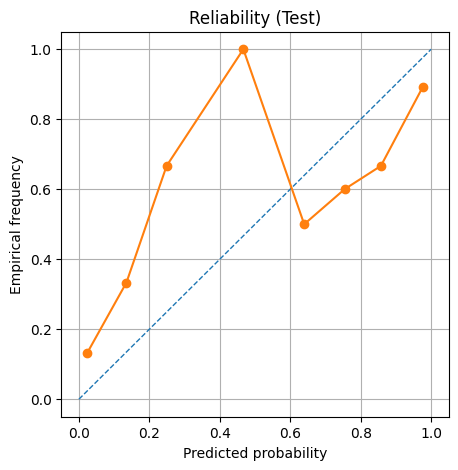

In [19]:
# === Reliability curve (test) ===
import numpy as np, pandas as pd, matplotlib.pyplot as plt

test_df = pd.DataFrame({
    'y': te['y'],
    'p': te['p']
})
bins = np.linspace(0,1,11)
test_df['bin'] = np.digitize(test_df['p'], bins) - 1
grp = test_df.groupby('bin').agg(
    avg_p=('p','mean'),
    frac_pos=('y','mean'),
    n=('y','size')
).dropna()

plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],'--',linewidth=1)
plt.plot(grp['avg_p'], grp['frac_pos'], marker='o')
plt.xlabel('Predicted probability'); plt.ylabel('Empirical frequency'); plt.title('Reliability (Test)')
plt.grid(True); plt.show()


In [20]:
# ==== CELL 8B — CEILING ANALYSIS vs MARKET (Brier Skill, Relative Efficiency, Logloss Ceiling) ====
import numpy as np, pandas as pd, torch
from pathlib import Path
from sklearn.metrics import log_loss

BASE = Path('/content/drive/MyDrive/nfl-win-transformer')
PROC = BASE/'data'/'processed'

df_all = pd.read_parquet(PROC/'game_rows.parquet').copy()

def _am2prob(ml):
    ml = np.asarray(ml, dtype=float)
    p  = np.empty_like(ml, dtype=float)
    pos = ml > 0
    p[pos]  = 100.0 / (ml[pos] + 100.0)
    p[~pos] = (-ml[~pos]) / ((-ml[~pos]) + 100.0)
    return p

def market_prob_home(block: pd.DataFrame) -> np.ndarray:
    ph = _am2prob(block['home_moneyline'].to_numpy()) if 'home_moneyline' in block else np.full(len(block), np.nan)
    pa = _am2prob(block['away_moneyline'].to_numpy()) if 'away_moneyline' in block else np.full(len(block), np.nan)
    s = ph + pa
    with np.errstate(divide='ignore', invalid='ignore'):
        pm = ph / s
    # Fallback to spread→prob if MLs are missing
    if 'spread_line' in block.columns:
        sp = block['spread_line'].astype(float).to_numpy()
        pm = np.where(np.isnan(pm), 1.0/(1.0 + np.exp(sp/6.0)), pm)
    return np.clip(pm, 1e-6, 1-1e-6)

@torch.no_grad()
def collect_p_with_T(loader, T_val):
    model.eval()
    out = []
    for batch in loader:
        for k in list(batch.keys()):
            batch[k] = batch[k].to(DEVICE) if isinstance(batch[k], torch.Tensor) else batch[k]
        logits = model(batch) / T_val
        out.append(torch.softmax(logits, dim=-1)[:,1].cpu().numpy())
    return np.clip(np.concatenate(out), 1e-6, 1-1e-6)

# Probabilities (temperature-scaled) aligned to valid/test loaders
p_valid_model = collect_p_with_T(valid_loader, T_star)
p_test_model  = collect_p_with_T(test_loader,  T_star)

y_valid = df_all.iloc[valid_idx]['y_home'].astype(int).to_numpy()
y_test  = df_all.iloc[test_idx]['y_home'].astype(int).to_numpy()

p_valid_mkt = market_prob_home(df_all.iloc[valid_idx])
p_test_mkt  = market_prob_home(df_all.iloc[test_idx])

def ceiling(y, p_model, p_mkt):
    y = y.astype(float)
    p_model = np.clip(p_model, 1e-6, 1-1e-6)
    p_mkt   = np.clip(p_mkt,   1e-6, 1-1e-6)

    # Brier + Skill vs base rate
    bs_model = float(np.mean((y - p_model)**2))
    bs_opt   = float(np.mean((y - p_mkt)**2))     # market as proxy for p*
    r        = float(np.mean(y))
    bs_ref   = r*(1-r)
    bss      = 1.0 - bs_model/bs_ref

    # Relative efficiency to ceiling
    eff_brier = (bs_ref - bs_model) / (bs_ref - bs_opt) if bs_ref > bs_opt else np.nan

    # Logloss + efficiency
    ll_model = float(log_loss(y, p_model))
    ll_opt   = float(log_loss(y, p_mkt))
    q        = np.clip(r, 1e-6, 1-1e-6)
    ll_ref   = float(-(r*np.log(q) + (1-r)*np.log(1-q)))
    eff_log  = (ll_ref - ll_model) / (ll_ref - ll_opt) if ll_ref > ll_opt else np.nan

    # Market entropy (irreducible expected logloss if p*=p_mkt)
    H_mkt = float(np.mean(-(p_mkt*np.log(p_mkt) + (1-p_mkt)*np.log(1-p_mkt))))

    return {
        'brier_model': bs_model,
        'brier_opt≈market': bs_opt,
        'brier_ref(base-rate)': bs_ref,
        'BSS_vs_base': bss,
        'RelEff_brier': eff_brier,
        'logloss_model': ll_model,
        'logloss_opt≈market': ll_opt,
        'logloss_ref(base-rate)': ll_ref,
        'RelEff_logloss': eff_log,
        'market_entropy': H_mkt
    }

print("\n[CEILING] VALID (2023)")
for k,v in ceiling(y_valid, p_valid_model, p_valid_mkt).items():
    print(f"  {k:24s} = {v:.6f}")

print("\n[CEILING] TEST (2024)")
for k,v in ceiling(y_test, p_test_model, p_test_mkt).items():
    print(f"  {k:24s} = {v:.6f}")



[CEILING] VALID (2023)
  brier_model              = 0.121455
  brier_opt≈market         = 0.218710
  brier_ref(base-rate)     = 0.246959
  BSS_vs_base              = 0.508196
  RelEff_brier             = 4.442709
  logloss_model            = 0.396276
  logloss_opt≈market       = 0.627349
  logloss_ref(base-rate)   = 0.687052
  RelEff_logloss           = 4.870326
  market_entropy           = 0.623044

[CEILING] TEST (2024)
  brier_model              = 0.112736
  brier_opt≈market         = 0.200162
  brier_ref(base-rate)     = 0.248905
  BSS_vs_base              = 0.547073
  RelEff_brier             = 2.793584
  logloss_model            = 0.376257
  logloss_opt≈market       = 0.587489
  logloss_ref(base-rate)   = 0.690956
  RelEff_logloss           = 3.041541
  market_entropy           = 0.625512


# **Cell 9A — Season walk-forward backtest (fast, good first pass)**

In [ ]:
# === Cell 9 — Season walk-forward backtest (scaler-driven, label-safe) ===
import json, numpy as np, pandas as pd, torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score, accuracy_score

# ------------------------------------------------------------------
# Paths and artifacts
# ------------------------------------------------------------------
BASE   = Path('/content/drive/MyDrive/nfl-win-transformer')
INTM   = BASE / 'data' / 'interim'
PROC   = BASE / 'data' / 'processed'
MODELD = BASE / 'models' / 'winpred' / 'best'

# Load table
df = pd.read_parquet(PROC / 'game_rows.parquet')

# Load scalers + column lists (from your Cell 7)
import pickle
with open(MODELD / 'scalers.pkl', 'rb') as f:
    sc_pack = pickle.load(f)
GAME_COLS  = sc_pack['game_cols']
HOME_COLS  = sc_pack['home_cols']
AWAY_COLS  = sc_pack['away_cols']
GAME_MEANS = sc_pack.get('game_means', {})
HOME_MEANS = sc_pack.get('home_means', {})
AWAY_MEANS = sc_pack.get('away_means', {})
GAME_SCALER = sc_pack['game']
HOME_SCALER = sc_pack['home']
AWAY_SCALER = sc_pack['away']

# Vocabularies (team/qb/coach indices)
from section_a_modeling_game_winner import load_vocabs
vocabs = load_vocabs(INTM / 'vocabs.json')

# Device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
SEED = 1337
import random
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# ------------------------------------------------------------------
# Helper transforms (scale/impute using saved scalers)
# ------------------------------------------------------------------
def _ensure_columns(frame, cols):
    for c in cols:
        if c not in frame.columns:
            frame[c] = np.nan

def _transform_block(frame: pd.DataFrame, cols, scaler, means) -> np.ndarray:
    """
    Returns scaled numeric array for the requested cols (float32).
    Fills NaN with training means to keep everything finite.
    """
    _ensure_columns(frame, cols)
    X = frame.loc[:, cols].apply(pd.to_numeric, errors='coerce')
    if means:
        fill = {c: means.get(c, 0.0) for c in cols}
        X = X.fillna(fill)
    else:
        X = X.fillna(0.0)
    # SKLearn scalers output float64 → cast to float32 for PyTorch
    return scaler.transform(X).astype(np.float32)

def _id_series(frame: pd.DataFrame, idx_col: str, fallback_col: str, mapping: dict) -> np.ndarray:
    """
    1) Use numeric index column if present
    2) else map fallback string column via provided vocab mapping
    3) unknown → 0
    """
    if idx_col in frame.columns:
        arr = pd.to_numeric(frame[idx_col], errors='coerce').fillna(-1).astype(int).to_numpy()
    elif fallback_col in frame.columns:
        arr = frame[fallback_col].astype(str).map(mapping).fillna(-1).astype(int).to_numpy()
    else:
        arr = np.zeros(len(frame), dtype=int) - 1
    return np.where(arr < 0, 0, arr)

# ------------------------------------------------------------------
# Model (same architecture you trained with)
# ------------------------------------------------------------------
class WinTransformer(nn.Module):
    """3 tokens: [GAME], [HOME], [AWAY]; class 1 == HOME; GAME-gated Bradley–Terry."""
    def __init__(self, n_teams, n_qbs, n_coaches, n_game, n_home, n_away,
                 d_model=256, heads=8, ffn=1024, layers=4, dropout=0.1):
        super().__init__()
        # IDs
        self.E_team  = nn.Embedding(n_teams, 32)
        self.E_qb    = nn.Embedding(n_qbs, 64)
        self.E_coach = nn.Embedding(n_coaches, 16)
        self.ids_proj = nn.Linear(32+64+16, d_model)
        self.emb_drop = nn.Dropout(0.05)
        # Numerics
        self.game_proj = nn.Linear(n_game, d_model)
        self.home_proj = nn.Linear(n_home, d_model)
        self.away_proj = nn.Linear(n_away, d_model)
        self.ln_game = nn.LayerNorm(d_model)
        self.ln_home = nn.LayerNorm(d_model)
        self.ln_away = nn.LayerNorm(d_model)
        # Encoder
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=heads, dim_feedforward=ffn,
            dropout=dropout, batch_first=True, activation='gelu', norm_first=False
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=layers)
        # Heads
        self.bt_linear = nn.Linear(d_model, 1)
        self.bt_gate   = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(d_model, 1),
        )

    def team_token(self, team_id, qb_id, coach_id, num_vec, proj, ln):
        ids = torch.cat([self.E_team(team_id), self.E_qb(qb_id), self.E_coach(coach_id)], dim=-1)
        tok = self.ids_proj(ids)
        tok = self.emb_drop(tok) + proj(num_vec)
        return ln(tok)

    def forward(self, batch):
        g = self.ln_game(self.game_proj(batch['game_num']))
        h = self.team_token(batch['home_team'], batch['home_qb'], batch['home_coach'],
                            batch['home_num'], self.home_proj, self.ln_home)
        a = self.team_token(batch['away_team'], batch['away_qb'], batch['away_coach'],
                            batch['away_num'], self.away_proj, self.ln_away)
        X = torch.stack([g, h, a], dim=1)  # (B,3,D)
        H = self.encoder(X)                # (B,3,D)
        d = H[:,1,:] - H[:,2,:]
        s = self.bt_linear(d).squeeze(-1) + self.bt_gate(d * H[:,0,:]).squeeze(-1)
        return torch.stack([-s, s], dim=-1)

# ------------------------------------------------------------------
# Dataset (scales/imputes inside; label from scores only when known)
# ------------------------------------------------------------------
class WinDatasetFold(Dataset):
    def __init__(self, idx):
        self.idx = np.asarray(idx, dtype=int)
        frame = df.iloc[self.idx].copy()

        # Scaled numerics (now float32)
        self.G = _transform_block(frame, GAME_COLS, GAME_SCALER, GAME_MEANS)  # float32
        self.H = _transform_block(frame, HOME_COLS, HOME_SCALER, HOME_MEANS)  # float32
        self.A = _transform_block(frame, AWAY_COLS, AWAY_SCALER, AWAY_MEANS)  # float32

        # IDs (unknown→0)
        self.home_team = _id_series(frame, 'home_team_id',  'home_team',   vocabs.team2idx)
        self.away_team = _id_series(frame, 'away_team_id',  'away_team',   vocabs.team2idx)
        self.home_qb   = _id_series(frame, 'home_qb_idx',   'home_qb_id',  vocabs.qb2idx)
        self.away_qb   = _id_series(frame, 'away_qb_idx',   'away_qb_id',  vocabs.qb2idx)
        self.home_co   = _id_series(frame, 'home_coach_idx','home_coach_id', vocabs.coach2idx)
        self.away_co   = _id_series(frame, 'away_coach_idx','away_coach_id', vocabs.coach2idx)

        # Label from scores (we only construct Dataset for score-known rows)
        hs = frame['home_score'].to_numpy(float)
        as_ = frame['away_score'].to_numpy(float)
        self.y = (hs > as_).astype(np.int64)

    def __len__(self): return len(self.idx)

    def __getitem__(self, k):
        return {
            # Explicit .float() to guarantee float32 tensors
            'game_num': torch.from_numpy(self.G[k]).float(),
            'home_num': torch.from_numpy(self.H[k]).float(),
            'away_num': torch.from_numpy(self.A[k]).float(),
            'home_team': torch.tensor(self.home_team[k], dtype=torch.long),
            'away_team': torch.tensor(self.away_team[k], dtype=torch.long),
            'home_qb':   torch.tensor(self.home_qb[k],   dtype=torch.long),
            'away_qb':   torch.tensor(self.away_qb[k],   dtype=torch.long),
            'home_coach':torch.tensor(self.home_co[k],   dtype=torch.long),
            'away_coach':torch.tensor(self.away_co[k],   dtype=torch.long),
            'y':         torch.tensor(self.y[k],         dtype=torch.long),
        }

def make_loader(idx, batch=256, shuffle=False):
    return DataLoader(WinDatasetFold(idx), batch_size=batch, shuffle=shuffle, num_workers=0)

# ------------------------------------------------------------------
# Fold utilities
# ------------------------------------------------------------------
def score_known_idx(idx_raw: np.ndarray) -> np.ndarray:
    """Keep only rows where both scores are present."""
    idx_raw = np.asarray(idx_raw, dtype=int)
    m = df.iloc[idx_raw]['home_score'].notna() & df.iloc[idx_raw]['away_score'].notna()
    return idx_raw[m.to_numpy()]

@torch.no_grad()
def eval_loader(model, loader, criterion):
    model.eval()
    ps, ys, tot_loss, n = [], [], 0.0, 0
    for batch in loader:
        for k in list(batch.keys()):
            batch[k] = batch[k].to(DEVICE) if isinstance(batch[k], torch.Tensor) else batch[k]
        logits = model(batch)
        loss = criterion(logits, batch['y'])
        p = torch.softmax(logits, dim=-1)[:,1].detach().cpu().numpy()
        y = batch['y'].detach().cpu().numpy()
        ps.append(p); ys.append(y)
        tot_loss += float(loss.item()) * y.shape[0]; n += y.shape[0]
    if n == 0:
        return {'logloss': np.nan, 'brier': np.nan, 'auc': np.nan, 'acc': np.nan, 'p': np.array([]), 'y': np.array([])}
    p = np.clip(np.concatenate(ps), 1e-7, 1-1e-7)
    y = np.concatenate(ys)
    out = dict(
        logloss=float(log_loss(y, p)),
        brier=float(brier_score_loss(y, p)),
        acc=float(accuracy_score(y, (p>=0.5).astype(int))),
        p=p, y=y
    )
    try:
        out['auc'] = float(roc_auc_score(y, p))
    except Exception:
        out['auc'] = np.nan
    return out

def create_model():
    return WinTransformer(
        n_teams=len(vocabs.team2idx), n_qbs=len(vocabs.qb2idx), n_coaches=len(vocabs.coach2idx),
        n_game=len(GAME_COLS), n_home=len(HOME_COLS), n_away=len(AWAY_COLS),
        d_model=256, heads=8, ffn=1024, layers=4, dropout=0.1
    ).to(DEVICE)

def train_one_fold(train_idx, valid_idx, epochs=8, lr=2e-4, wd=0.05, patience=2):
    train_loader = make_loader(train_idx, shuffle=True)
    valid_loader = make_loader(valid_idx, shuffle=False)
    model = create_model()
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
    criterion = nn.CrossEntropyLoss()

    best, waited = (1e9, None), 0
    for ep in range(1, epochs+1):
        # train
        model.train()
        run_loss, n = 0.0, 0
        for batch in train_loader:
            for k in list(batch.keys()):
                batch[k] = batch[k].to(DEVICE) if isinstance(batch[k], torch.Tensor) else batch[k]
            logits = model(batch)
            loss = criterion(logits, batch['y'])
            opt.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            run_loss += float(loss.item()) * logits.size(0); n += logits.size(0)
        # valid
        va = eval_loader(model, valid_loader, criterion)
        print(f"  ep{ep:02d} | train {run_loss/max(n,1):.4f} | valid logloss {va['logloss']:.4f} "
              f"AUC {va['auc']:.3f} ACC {va['acc']:.3f}")
        if np.isfinite(va['logloss']) and (va['logloss'] < best[0] - 1e-4):
            best = (va['logloss'], model.state_dict()); waited = 0
        else:
            waited += 1
            if waited >= patience: break
    if best[1] is not None:
        model.load_state_dict(best[1])
    # final eval (raw)
    va = eval_loader(model, valid_loader, criterion)
    return model, va, valid_loader

# --- Temperature scaling per fold (on the fold's validation) ---
@torch.no_grad()
def collect_logits_and_labels(model, loader):
    model.eval()
    Ls, Ys = [], []
    for batch in loader:
        for k in list(batch.keys()):
            batch[k] = batch[k].to(DEVICE) if isinstance(batch[k], torch.Tensor) else batch[k]
        Ls.append(model(batch).detach().cpu())
        Ys.append(batch['y'].detach().cpu())
    if not Ls:
        return torch.zeros((0,2)), torch.zeros((0,), dtype=torch.long)
    return torch.cat(Ls, 0), torch.cat(Ys, 0)

def eval_with_T(model, loader, T_val):
    model.eval()
    ps, ys = [], []
    with torch.no_grad():
        for batch in loader:
            for k in list(batch.keys()):
                batch[k] = batch[k].to(DEVICE) if isinstance(batch[k], torch.Tensor) else batch[k]
            logits = model(batch) / T_val
            ps.append(torch.softmax(logits, dim=-1)[:,1].cpu().numpy())
            ys.append(batch['y'].cpu().numpy())
    if not ps:
        return {'logloss': np.nan, 'brier': np.nan, 'auc': np.nan, 'acc': np.nan}
    p = np.clip(np.concatenate(ps), 1e-7, 1-1e-7)
    y = np.concatenate(all_y) if (all_y := ys) else np.array([])
    return dict(
        logloss=float(log_loss(y, p)),
        brier=float(brier_score_loss(y, p)),
        auc=float(roc_auc_score(y, p)) if len(np.unique(y)) > 1 else np.nan,
        acc=float(accuracy_score(y, (p>=0.5).astype(int)))
    )

def learn_temperature(val_logits, val_y, iters=25):
    T = torch.nn.Parameter(torch.tensor(1.0))
    optT = torch.optim.LBFGS([T], lr=0.1, max_iter=50)
    def _closure():
        optT.zero_grad()
        if val_logits.numel() == 0:
            loss = torch.tensor(0.0, requires_grad=True)
        else:
            loss = nn.CrossEntropyLoss()(val_logits / T, val_y)
        loss.backward()
        return loss
    for _ in range(iters):
        optT.step(_closure)
    return float(T.detach().cpu().item())

# ------------------------------------------------------------------
# Run the walk-forward
# ------------------------------------------------------------------
seasons = sorted(df['season'].unique())
rows = []
for S in seasons:
    tr_raw = np.where(df['season'] <  S)[0]
    va_raw = np.where(df['season'] == S)[0]
    tr_idx = score_known_idx(tr_raw)
    va_idx = score_known_idx(va_raw)

    print(f"\n=== Fold: season {S}  (train<{S}: {len(tr_raw)} -> {len(tr_idx)} OK, "
          f"valid=={S}: {len(va_raw)} -> {len(va_idx)} OK)")
    if len(tr_idx) == 0:
        print("  [SKIP] No training history prior to this season."); continue
    if len(va_idx) == 0:
        print("  [SKIP] No evaluable rows this season (no final scores yet)."); continue

    model, va_raw_metrics, valid_loader = train_one_fold(tr_idx, va_idx, epochs=8, patience=2)
    # Temperature scaling on this fold’s validation
    val_logits, val_y = collect_logits_and_labels(model, valid_loader)
    T_star = learn_temperature(val_logits, val_y)
    va_cal = eval_with_T(model, valid_loader, T_star)

    rows.append({
        'season': int(S),
        'logloss': va_cal['logloss'],
        'brier':   va_cal['brier'],
        'auc':     va_cal['auc'],
        'acc':     va_cal['acc'],
        'T_star':  T_star
    })

# Results table
if rows:
    mf = pd.DataFrame(rows).set_index('season').sort_index()
    print("\nPer-season metrics (temperature‑calibrated):\n", mf.round(4))
    print("\nMacro average:\n", mf[['logloss','brier','auc','acc']].mean().round(4))
else:
    print("\nNo evaluable folds (likely no seasons with completed scores).")



=== Fold: season 2018  (train<2018: 0 -> 0 OK, valid==2018: 254 -> 254 OK)
  [SKIP] No training history prior to this season.

=== Fold: season 2019  (train<2019: 254 -> 254 OK, valid==2019: 255 -> 255 OK)
  ep01 | train 0.9200 | valid logloss 0.7801 AUC 0.570 ACC 0.545
  ep02 | train 0.5878 | valid logloss 0.6446 AUC 0.713 ACC 0.682
  ep03 | train 0.3753 | valid logloss 0.5695 AUC 0.789 ACC 0.725
  ep04 | train 0.2697 | valid logloss 0.5254 AUC 0.824 ACC 0.749
  ep05 | train 0.1962 | valid logloss 0.4941 AUC 0.847 ACC 0.749
  ep06 | train 0.1221 | valid logloss 0.4730 AUC 0.861 ACC 0.780
  ep07 | train 0.0832 | valid logloss 0.4594 AUC 0.872 ACC 0.788
  ep08 | train 0.0527 | valid logloss 0.4525 AUC 0.880 ACC 0.804

=== Fold: season 2020  (train<2020: 509 -> 509 OK, valid==2020: 255 -> 255 OK)
  ep01 | train 0.7015 | valid logloss 0.5759 AUC 0.774 ACC 0.706
  ep02 | train 0.3464 | valid logloss 0.4902 AUC 0.848 ACC 0.765
  ep03 | train 0.2081 | valid logloss 0.4499 AUC 0.880 ACC 0.80

# **Cell 9B — Weekly walk-forward backtest (2024) (more “live”)**

In [ ]:
import torch.nn.functional as F
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import log_loss, brier_score_loss, roc_auc_score, accuracy_score

@torch.no_grad()
def collect_logits_and_labels(model, idx):
    loader = make_loader(idx, shuffle=False)
    model.eval()
    L, Y = [], []
    for batch in loader:
        for k in list(batch.keys()):
            batch[k] = batch[k].to(DEVICE) if isinstance(batch[k], torch.Tensor) else batch[k]
        logits = model(batch)
        L.append(logits.detach().cpu())
        Y.append(batch['y'].detach().cpu())
    if not L:
        return torch.zeros((0,2)), torch.zeros((0,), dtype=torch.long)
    return torch.cat(L,0), torch.cat(Y,0)

def learn_safe_temperature_on_idx(model, calib_idx, T_min=0.9, T_max=2.0):
    logits, y = collect_logits_and_labels(model, calib_idx)
    if y.numel() == 0 or len(np.unique(y.numpy())) < 2:
        return 1.0  # not enough info
    tau = torch.nn.Parameter(torch.tensor(0.0))     # T = softplus(tau)+eps > 0
    optT = torch.optim.LBFGS([tau], lr=0.1, max_iter=50)
    eps = 1e-3
    def _closure():
        optT.zero_grad()
        T = F.softplus(tau) + eps
        loss = torch.nn.CrossEntropyLoss()(logits / T, y)
        loss.backward()
        return loss
    for _ in range(15):
        optT.step(_closure)
    T_val = float(F.softplus(tau).item() + eps)
    T_val = float(min(max(T_val, T_min), T_max))  # clamp
    # fallback if this T makes calib logloss worse than T=1
    p0 = torch.softmax(logits, dim=-1)[:,1].numpy()
    pT = torch.softmax(logits / T_val, dim=-1)[:,1].numpy()
    y_np = y.numpy()
    if log_loss(y_np, np.clip(pT,1e-7,1-1e-7)) >= log_loss(y_np, np.clip(p0,1e-7,1-1e-7)):
        T_val = 1.0
    return T_val

@torch.no_grad()
def eval_with_T(model, idx, T):
    loader = make_loader(idx, shuffle=False)
    model.eval()
    P, Y = [], []
    for batch in loader:
        for k in list(batch.keys()):
            batch[k] = batch[k].to(DEVICE) if isinstance(batch[k], torch.Tensor) else batch[k]
        logits = model(batch) / T
        P.append(torch.softmax(logits, dim=-1)[:,1].cpu().numpy())
        Y.append(batch['y'].cpu().numpy())
    p = np.clip(np.concatenate(P), 1e-7, 1-1e-7); y = np.concatenate(Y).astype(int)
    return dict(
        logloss=float(log_loss(y,p)),
        brier=float(brier_score_loss(y,p)),
        auc=float(roc_auc_score(y,p)),
        acc=float(accuracy_score(y,(p>=0.5).astype(int))),
        T_star=float(T),
    )

# --- Weekly walk-forward with PRIOR-WEEK calibration set ---
weeks_2024 = sorted(df.query("season==2024")['week'].unique())
weekly_metrics = []
for w in weeks_2024:
    if w <= 1:  # need at least one prior week
        continue
    prior = (df['season'] < 2024) | ((df['season']==2024) & (df['week'] < w))
    idx_all_prior = np.where(prior & df['y_home'].isin([0,1]))[0]
    valid_idx = np.where((df['season']==2024) & (df['week']==w) & df['y_home'].isin([0,1]))[0]
    if len(valid_idx) == 0 or len(idx_all_prior) < 64:
        # Too few prior games to calibrate: fall back to a global T (e.g., 1.55)
        tr_idx = idx_all_prior
        res = train_one_fold(tr_idx, valid_idx, epochs=6, patience=2)
        model = res[0]
        m = eval_with_T(model, valid_idx, 1.55)
        m['week'] = int(w); weekly_metrics.append(m); continue

    # carve out a small PRIOR calibration subset (stratified)
    y_prior = df.loc[idx_all_prior,'y_home'].astype(int).to_numpy()
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    tr_rel, cal_rel = next(sss.split(np.zeros_like(y_prior), y_prior))
    tr_idx  = idx_all_prior[tr_rel]
    cal_idx = idx_all_prior[cal_rel]

    print(f"\n=== 2024 week {w:02d} | train up to week {w-1}: {len(tr_idx)} | calib prior: {len(cal_idx)} | eval: {len(valid_idx)}")
    res = train_one_fold(tr_idx, cal_idx, epochs=6, patience=2)  # early stop on prior calib
    model = res[0]
    T_week = learn_safe_temperature_on_idx(model, cal_idx, T_min=0.9, T_max=2.0)
    m = eval_with_T(model, valid_idx, T_week)
    m['week'] = int(w)
    weekly_metrics.append(m)

mw = pd.DataFrame(weekly_metrics).set_index('week').sort_index()
print("\nPer-week metrics (2024, prior‑weeks calibrated T):\n", mw.round(4))
print("\nMacro average (2024):\n", mw[['logloss','brier','auc','acc']].mean().round(4))




=== 2024 week 02 | train up to week 1: 1273 | calib prior: 319 | eval: 16
  ep01 | train 0.6043 | valid logloss 0.4688 AUC 0.865 ACC 0.793
  ep02 | train 0.3024 | valid logloss 0.4125 AUC 0.904 ACC 0.809
  ep03 | train 0.1779 | valid logloss 0.4063 AUC 0.915 ACC 0.831
  ep04 | train 0.1029 | valid logloss 0.4435 AUC 0.916 ACC 0.831
  ep05 | train 0.0522 | valid logloss 0.4882 AUC 0.919 ACC 0.846

=== 2024 week 03 | train up to week 2: 1286 | calib prior: 322 | eval: 16
  ep01 | train 0.6553 | valid logloss 0.5379 AUC 0.827 ACC 0.755
  ep02 | train 0.3051 | valid logloss 0.4463 AUC 0.890 ACC 0.826
  ep03 | train 0.1826 | valid logloss 0.4192 AUC 0.907 ACC 0.854
  ep04 | train 0.1097 | valid logloss 0.4417 AUC 0.915 ACC 0.842
  ep05 | train 0.0602 | valid logloss 0.5264 AUC 0.908 ACC 0.851

=== 2024 week 04 | train up to week 3: 1299 | calib prior: 325 | eval: 16
  ep01 | train 0.6100 | valid logloss 0.4729 AUC 0.866 ACC 0.797
  ep02 | train 0.2821 | valid logloss 0.4379 AUC 0.898 ACC 0

# **Cell 10 — Meta-blend (model + market) + overlay list**

In [21]:
# === Cell 10 — Robust meta-blend v2: Platt on UNCAPPED logit; adaptive caps for meta features; guarded overlays ===
import os, numpy as np, pandas as pd, torch, pickle
from pathlib import Path
from sklearn.metrics import (
    log_loss, brier_score_loss, roc_auc_score, accuracy_score, mean_absolute_error, mean_squared_error
)
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

# -----------------------------------------------------------------------------------
# Compat helpers
# -----------------------------------------------------------------------------------
def american_to_prob(o):
    if pd.isna(o): return np.nan
    o = float(o)
    return (-o)/(-o+100.0) if o < 0 else 100.0/(o+100.0)

def safe_logit(p, eps=1e-9):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

# scikit-learn version-agnostic RMSE
def rmse_compat(y_true, y_pred):
    try:
        return float(mean_squared_error(y_true, y_pred, squared=False))
    except TypeError:
        y_true = np.asarray(y_true, dtype=float)
        y_pred = np.asarray(y_pred, dtype=float)
        return float(np.sqrt(np.mean((y_true - y_pred) ** 2)))

# Prefer first existing column from a list; otherwise default
def _prefer(df: pd.DataFrame, names, default=np.nan) -> np.ndarray:
    for n in names:
        if n in df.columns:
            return df[n].to_numpy()
    return np.full(len(df), default, dtype=float)

# -----------------------------------------------------------------------------------
# Inputs expected from previous cells: df, model, DEVICE, T_star, valid_loader, test_loader
# Also: MODEL_DIR (where score_models.pkl lives). Provide a safe default if missing.
# -----------------------------------------------------------------------------------
try:
    MODEL_DIR
except NameError:
    BASE = Path(os.getenv('NFL_PROJ_DIR', '/content/drive/MyDrive/nfl-win-transformer'))
    MODEL_DIR = BASE / 'models' / 'winpred' / 'best'

# aligned ids straight from loaders
VAL_IDS  = np.asarray(valid_loader.dataset.idx)
TEST_IDS = np.asarray(test_loader.dataset.idx)

# Ensure margin exists and backfill where both scores are known
if 'margin' not in df.columns:
    df['margin'] = df['home_score'] - df['away_score']
else:
    m_fill = df['margin'].isna() & df['home_score'].notna() & df['away_score'].notna()
    df.loc[m_fill, 'margin'] = df.loc[m_fill, 'home_score'] - df.loc[m_fill, 'away_score']

# -----------------------------------------------------------------------------------
# Collect temperature-scaled model probabilities on valid/test
# -----------------------------------------------------------------------------------
@torch.no_grad()
def collect_probs_with_T(loader, T_val):
    model.eval()
    ps, ys = [], []
    for batch in loader:
        for k in list(batch.keys()):
            batch[k] = batch[k].to(DEVICE) if isinstance(batch[k], torch.Tensor) else batch[k]
        logits = model(batch) / T_val
        ps.append(torch.softmax(logits, dim=-1)[:, 1].cpu().numpy())
        ys.append(batch['y'].cpu().numpy())
    return np.concatenate(ys), np.concatenate(ps)

y_val,  p_model_val  = collect_probs_with_T(valid_loader, T_star)
y_test, p_model_test = collect_probs_with_T(test_loader,  T_star)

# -----------------------------------------------------------------------------------
# Load home/away score models (for predicted points/margin) — REBUILD X WITH SCALERS
# -----------------------------------------------------------------------------------
import pickle

with open(MODEL_DIR / 'score_models.pkl', 'rb') as f:
    score_pack = pickle.load(f)

score_feature_cols = list(score_pack['feature_cols'])
home_score_model = score_pack['home_model']
away_score_model = score_pack['away_model']

# ---- Load the scalers/means/column lists saved by Cell 7
with open(MODEL_DIR / 'scalers.pkl', 'rb') as f:
    sc_pack = pickle.load(f)
GAME_COLS  = list(sc_pack['game_cols'])
HOME_COLS  = list(sc_pack['home_cols'])
AWAY_COLS  = list(sc_pack['away_cols'])
GAME_SCALER = sc_pack['game'];  HOME_SCALER = sc_pack['home'];  AWAY_SCALER = sc_pack['away']
GAME_MEANS  = sc_pack.get('game_means', {})
HOME_MEANS  = sc_pack.get('home_means', {})
AWAY_MEANS  = sc_pack.get('away_means', {})

def _transform_block(df_like, cols, scaler, means):
    X = df_like.loc[:, cols].apply(pd.to_numeric, errors='coerce')
    X = X.fillna({c: means.get(c, 0.0) for c in cols})
    return scaler.transform(X).astype('float32')

# Build index maps ONCE
idxG = {c:i for i,c in enumerate(GAME_COLS)}
idxH = {c:i for i,c in enumerate(HOME_COLS)}
idxA = {c:i for i,c in enumerate(AWAY_COLS)}

def _build_score_X(df_like: pd.DataFrame) -> np.ndarray:
    """
    Recreate the EXACT design matrix used to train the score models:
    - scale/impute each block with the saved scalers + means
    - concatenate columns in score_feature_cols order (GAME | HOME | AWAY)
    """
    G = _transform_block(df_like, GAME_COLS, GAME_SCALER, GAME_MEANS)
    H = _transform_block(df_like, HOME_COLS, HOME_SCALER, HOME_MEANS)
    A = _transform_block(df_like, AWAY_COLS, AWAY_SCALER, AWAY_MEANS)

    N = len(df_like)
    parts = []
    for c in score_feature_cols:
        if c in idxG: parts.append(G[:, idxG[c]])
        elif c in idxH: parts.append(H[:, idxH[c]])
        elif c in idxA: parts.append(A[:, idxA[c]])
        else:
            # Should not happen; keep shape stable if something drifted
            parts.append(np.zeros((N,), dtype='float32'))
    X = np.stack(parts, axis=1)
    # Safety: ensure no NaNs
    if not np.isfinite(X).all():
        raise RuntimeError("Non-finite values in score feature matrix; check scalers/means.")
    return X

# ---- Build VALID/TEST score matrices in training order and scale
X_val_scores  = _build_score_X(df.iloc[VAL_IDS])
X_test_scores = _build_score_X(df.iloc[TEST_IDS])

# ---- Predict
home_val_score  = home_score_model.predict(X_val_scores).astype('float32')
away_val_score  = away_score_model.predict(X_val_scores).astype('float32')
home_test_score = home_score_model.predict(X_test_scores).astype('float32')
away_test_score = away_score_model.predict(X_test_scores).astype('float32')


# -----------------------------------------------------------------------------------
# Market probabilities (home win) on the same rows
# -----------------------------------------------------------------------------------
df_meta = df.copy()
df_meta['p_home_raw'] = df_meta['home_moneyline'].apply(american_to_prob)
df_meta['p_away_raw'] = df_meta['away_moneyline'].apply(american_to_prob)
s = df_meta['p_home_raw'] + df_meta['p_away_raw']
p_home_mkt = np.where(s > 0, df_meta['p_home_raw'] / s, np.nan).astype(float)

p_mkt_val,  p_mkt_test  = p_home_mkt[VAL_IDS], p_home_mkt[TEST_IDS]
m_val  = ~np.isnan(p_mkt_val)
m_test = ~np.isnan(p_mkt_test)

# Orient market (flip if AUC < 0.5) using valid rows with market
if m_val.any() and len(np.unique(y_val[m_val])) >= 2:
    auc_raw = roc_auc_score(y_val[m_val].astype(int), p_mkt_val[m_val])
    mkt_flipped = bool(auc_raw < 0.5)
else:
    auc_raw = np.nan
    mkt_flipped = False

if mkt_flipped:
    p_mkt_val  = 1.0 - p_mkt_val
    p_mkt_test = 1.0 - p_mkt_test

print(f"[MKT ORIENT] flipped={mkt_flipped}  auc_raw={auc_raw:.3f}" if np.isfinite(auc_raw) else "[MKT ORIENT] no usable market rows on valid; skip flip")

# -----------------------------------------------------------------------------------
# Platt calibration on UNCAPPED logit (valid rows with market)
# -----------------------------------------------------------------------------------
if m_val.any() and len(np.unique(y_val[m_val])) >= 2:
    z_val_uncap = safe_logit(p_mkt_val[m_val])
    y_val_int   = y_val[m_val].astype(int)
    platt = LogisticRegression(C=1.0, solver='lbfgs', max_iter=2000)
    platt.fit(z_val_uncap.reshape(-1, 1), y_val_int)
    a, b = float(platt.coef_[0, 0]), float(platt.intercept_[0])
    print(f"[MKT CAL] a={a:.3f} b={b:.3f}")

    def platt_cal(p):
        z = safe_logit(p)
        return 1.0 / (1.0 + np.exp(-(a * z + b)))

    p_mkt_val_cal  = np.full_like(p_mkt_val,  np.nan, dtype=float);  p_mkt_val_cal[m_val]  = platt_cal(p_mkt_val[m_val])
    p_mkt_test_cal = np.full_like(p_mkt_test, np.nan, dtype=float);  p_mkt_test_cal[m_test] = platt_cal(p_mkt_test[m_test])
else:
    print("[MKT CAL] No market rows with both classes on valid; using raw market probs.")
    p_mkt_val_cal, p_mkt_test_cal = p_mkt_val, p_mkt_test

# -----------------------------------------------------------------------------------
# META features: adaptive caps (99th pct of |logit| on valid with market)
# -----------------------------------------------------------------------------------
if m_val.any():
    z_model_val = safe_logit(p_model_val[m_val])
    z_mkt_val   = safe_logit(p_mkt_val_cal[m_val])
    cap_model   = float(np.quantile(np.abs(z_model_val), 0.99))
    cap_mkt     = float(np.quantile(np.abs(z_mkt_val),   0.99))
else:
    # fallback caps if no market present on valid
    cap_model, cap_mkt = 4.0, 4.0

# keep caps in a sensible range
cap_model = float(min(max(cap_model, 2.5), 8.0))
cap_mkt   = float(min(max(cap_mkt,   2.5), 8.0))
print(f"[META] caps: model={cap_model:.2f} market={cap_mkt:.2f}")

def clip(x, c): return np.clip(x, -c, c)

Z_val  = np.column_stack([clip(safe_logit(p_model_val),  cap_model),
                          clip(safe_logit(p_mkt_val_cal), cap_mkt)])
Z_test = np.column_stack([clip(safe_logit(p_model_test), cap_model),
                          clip(safe_logit(p_mkt_test_cal), cap_mkt)])

# -----------------------------------------------------------------------------------
# Meta logistic (train on valid rows with market; evaluate on valid holdout & test)
# -----------------------------------------------------------------------------------
if m_val.any() and len(np.unique(y_val[m_val])) >= 2:
    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.30, random_state=42)
    tr_idx, ho_idx = next(sss.split(Z_val[m_val], y_val[m_val].astype(int)))

    Z_tr, y_tr = Z_val[m_val][tr_idx], y_val[m_val][tr_idx].astype(int)
    Z_ho, y_ho = Z_val[m_val][ho_idx], y_val[m_val][ho_idx].astype(int)

    sc = StandardScaler().fit(Z_tr)
    X_tr, X_ho = sc.transform(Z_tr), sc.transform(Z_ho)
    X_te = sc.transform(Z_test[m_test]) if m_test.any() else None

    meta = LogisticRegression(C=1.0, solver='lbfgs', max_iter=2000)
    meta.fit(X_tr, y_tr)

    def evaluate(y, pm, pk, mask):
        X = sc.transform(np.column_stack([clip(safe_logit(pm[mask]), cap_model),
                                          clip(safe_logit(pk[mask]), cap_mkt)]))
        p = meta.predict_proba(X)[:, 1]
        return dict(
            logloss=float(log_loss(y[mask], p)),
            brier=float(brier_score_loss(y[mask], p)),
            auc=float(roc_auc_score(y[mask], p)),
            acc=float(accuracy_score(y[mask], (p >= 0.5).astype(int)))
        ), p

    val_indices = np.where(m_val)[0]
    val_holdout_mask = np.zeros_like(m_val, dtype=bool)
    val_holdout_mask[val_indices[ho_idx]] = True

    val_meta, p_val_meta = evaluate(y_val.astype(int),  p_model_val,  p_mkt_val_cal,  val_holdout_mask)
    print("[META CAL] VALID_HO:", {k: round(v, 4) for k, v in val_meta.items()})

    if m_test.any():
        test_meta, p_te_meta = evaluate(y_test.astype(int), p_model_test, p_mkt_test_cal, m_test)
        print("[META CAL] TEST    :", {k: round(v, 4) for k, v in test_meta.items()})
        p_meta_test = np.full_like(p_mkt_test_cal, np.nan); p_meta_test[m_test] = p_te_meta
    else:
        print("[META CAL] No market on test; using model probs for overlays.")
        p_meta_test = p_model_test.copy()
else:
    print("[META CAL] No market rows (with both classes) on valid; using model probs for overlays.")
    p_meta_test = p_model_test.copy()

# -----------------------------------------------------------------------------------
# Guarded overlays (avoid extremes; edges between 0.05 and 0.30 by abs)
# -----------------------------------------------------------------------------------
# Build output frame aligned to TEST set (only rows with market if available)
rows_test = np.where(m_test)[0] if m_test.any() else np.arange(len(TEST_IDS))
out = pd.DataFrame({
    'game_id':        df.iloc[TEST_IDS].iloc[rows_test]['game_id'].values,
    'season':         df.iloc[TEST_IDS].iloc[rows_test]['season'].values,
    'week':           df.iloc[TEST_IDS].iloc[rows_test]['week'].values,
    'home_team':      df.iloc[TEST_IDS].iloc[rows_test]['home_team'].values,
    'away_team':      df.iloc[TEST_IDS].iloc[rows_test]['away_team'].values,
    'p_market_cal':   (p_mkt_test_cal[rows_test] if m_test.any() else np.full(len(rows_test), np.nan)),
    'p_model':        p_model_test[rows_test],
    'p_meta':         p_meta_test[rows_test],
    'pred_home_score': home_test_score[rows_test],
    'pred_away_score': away_test_score[rows_test],
})

out['edge']        = out['p_meta'] - out['p_market_cal']
out['pred_margin'] = out['pred_home_score'] - out['pred_away_score']
out['pred_total']  = out['pred_home_score'] + out['pred_away_score']

# Guardrails: both probs mid-range (if market exists) + edge range
ov = out.copy()
if ov['p_market_cal'].notna().any():
    ov = ov.query("p_market_cal >= 0.10 and p_market_cal <= 0.90 and p_meta >= 0.10 and p_meta <= 0.90")
    ov = ov[(ov['edge'].abs() >= 0.05) & (ov['edge'].abs() <= 0.30)]
else:
    # If no market, just bound model prob to mid-range (edge won't be meaningful)
    ov = ov.query("p_meta >= 0.10 and p_meta <= 0.90")

ov = ov.reindex(ov['edge'].abs().sort_values(ascending=False).index if 'edge' in ov.columns else ov.index)

print("\n[OVERLAYS guarded] top 10:")
cols_show = ['season','week','home_team','away_team','p_market_cal','p_model','p_meta','edge']
print(ov[[c for c in cols_show if c in ov.columns]].head(10).to_string(index=False))


[MKT ORIENT] flipped=False  auc_raw=0.695
[MKT CAL] a=0.923 b=0.034
[META] caps: model=2.50 market=2.50
[META CAL] VALID_HO: {'logloss': 0.4262, 'brier': 0.1354, 'auc': 0.9076, 'acc': 0.8293}
[META CAL] TEST    : {'logloss': 0.3669, 'brier': 0.1106, 'auc': 0.9221, 'acc': 0.8566}

[OVERLAYS guarded] top 10:
 season  week home_team away_team  p_market_cal  p_model   p_meta      edge
   2024    17       PIT        KC      0.421962 0.115739 0.124240 -0.297722
   2024     9       ATL       DAL      0.600263 0.881090 0.896263  0.296000
   2024    12       LAC       BAL      0.416113 0.113221 0.120652 -0.295460
   2024     7       NYG       PHI      0.416113 0.114826 0.122254 -0.293859
   2024     8       SEA       BUF      0.412266 0.113127 0.119866 -0.292401
   2024     3       ATL        KC      0.412266 0.114073 0.120804 -0.291462
   2024    17       CLE       MIA      0.412266 0.114297 0.121027 -0.291239
   2024    12       LAR       PHI      0.412266 0.114333 0.121063 -0.291204
   2024 

In [22]:
# === Optional shrink step: tune lambda on validation holdout and compute shrunk overlays ===
lam_candidates = np.linspace(0.0, 1.0, 201)
val_mask_idx = np.where(val_holdout_mask)[0]
if val_mask_idx.size:
    y_val_holdout = y_val[val_holdout_mask].astype(int)
    p_mkt_holdout = p_mkt_val_cal[val_holdout_mask]
    p_meta_holdout = p_val_meta
    best_loss, lam_star = float('inf'), 0.0
    for lam in lam_candidates:
        mix = lam * p_meta_holdout + (1.0 - lam) * p_mkt_holdout
        mix = np.clip(mix, 1e-6, 1-1e-6)
        loss = log_loss(y_val_holdout, mix)
        if loss < best_loss:
            best_loss, lam_star = loss, float(lam)
    print(f"[SHRINK] tuned lambda={lam_star:.3f} (holdout logloss {best_loss:.4f})")
else:
    lam_star = 0.9
    print('[SHRINK] holdout mask empty; defaulting lambda to 0.90')
ov_shrunk = out.copy()
ov_shrunk['p_meta_shrunk'] = lam_star * ov_shrunk['p_meta'] + (1.0 - lam_star) * ov_shrunk['p_market_cal']
ov_shrunk['edge_shrunk'] = ov_shrunk['p_meta_shrunk'] - ov_shrunk['p_market_cal']


[SHRINK] tuned lambda=0.960 (holdout logloss 0.4257)


# **Cell 11 Export guarded overlays per week (shrunk meta)**

In [23]:
# === Cell 11 — Export guarded overlays per week (shrunk meta) ===
import pandas as pd, numpy as np
from pathlib import Path

EXPO = BASE/'data'/'processed'/'overlays'
EXPO.mkdir(parents=True, exist_ok=True)

df_ex = pd.DataFrame({
    'game_id': out['game_id'],
    'season': out['season'],
    'week': out['week'],
    'home_team': out['home_team'],
    'away_team': out['away_team'],
    'p_market_cal': out['p_market_cal'],
    'p_model': out['p_model'],
    'p_meta': out['p_meta'],  # from unshrunk meta
})
# add shrunk outputs if you ran the shrink step:
if 'p_meta_shrunk' in locals():
    df_ex['p_meta_shrunk'] = ov_shrunk['p_meta_shrunk'].reindex(df_ex.index)
    df_ex['edge_shrunk']   = ov_shrunk['edge_shrunk'].reindex(df_ex.index)

# filter to your target season (e.g., 2024)
season_sel = 2024
weeks = sorted(df_ex.query("season == @season_sel")['week'].unique())
for w in weeks:
    sub = df_ex.query("season == @season_sel and week == @w").copy()
    # guardrails (mid-range probs + edge band)
    if 'edge_shrunk' in sub:
        keep = (sub['p_market_cal'].between(0.10,0.90)
                & sub['p_meta_shrunk'].between(0.10,0.90)
                & sub['edge_shrunk'].abs().between(0.05,0.20))
        sub = sub[keep]
        sub = sub.sort_values('edge_shrunk', key=np.abs, ascending=False)
    else:
        keep = (sub['p_market_cal'].between(0.10,0.90)
                & sub['p_meta'].between(0.10,0.90)
                & (sub['p_meta'] - sub['p_market_cal']).abs().between(0.05,0.20))
        sub = sub[keep]
        sub = sub.assign(edge=sub['p_meta']-sub['p_market_cal']).sort_values('edge', key=np.abs, ascending=False)

    out_csv = EXPO/f"overlays_{season_sel}_wk{w:02d}.csv"
    sub.to_csv(out_csv, index=False)
    print("WROTE overlays:", out_csv, "| rows:", len(sub))


WROTE overlays: /content/drive/MyDrive/nfl-win-transformer/data/processed/overlays/overlays_2024_wk01.csv | rows: 0
WROTE overlays: /content/drive/MyDrive/nfl-win-transformer/data/processed/overlays/overlays_2024_wk02.csv | rows: 1
WROTE overlays: /content/drive/MyDrive/nfl-win-transformer/data/processed/overlays/overlays_2024_wk03.csv | rows: 3
WROTE overlays: /content/drive/MyDrive/nfl-win-transformer/data/processed/overlays/overlays_2024_wk04.csv | rows: 1
WROTE overlays: /content/drive/MyDrive/nfl-win-transformer/data/processed/overlays/overlays_2024_wk05.csv | rows: 1
WROTE overlays: /content/drive/MyDrive/nfl-win-transformer/data/processed/overlays/overlays_2024_wk06.csv | rows: 1
WROTE overlays: /content/drive/MyDrive/nfl-win-transformer/data/processed/overlays/overlays_2024_wk07.csv | rows: 0
WROTE overlays: /content/drive/MyDrive/nfl-win-transformer/data/processed/overlays/overlays_2024_wk08.csv | rows: 1
WROTE overlays: /content/drive/MyDrive/nfl-win-transformer/data/processe

# **Cell 12: Save meta artifacts for reuse**

In [24]:
# === Cell 12 — Save meta artifacts for reuse ===
import json, numpy as np
ART = BASE/'models'/'winpred'/'best'/'meta_artifacts.json'
art = {
    'platt_a': a, 'platt_b': b,
    'cap_model': cap_model, 'cap_market': cap_mkt,
    'scaler_mean': sc.mean_.tolist(), 'scaler_scale': sc.scale_.tolist(),
    'meta_coef': meta.coef_.ravel().tolist(), 'meta_intercept': float(meta.intercept_[0]),
    'shrink_lambda': float(lam_star) if 'lam_star' in locals() else None,
    'mkt_flip': bool(mkt_flipped)
}
with open(ART,'w') as f: json.dump(art, f, indent=2)
print("Saved meta artifacts:", ART)


Saved meta artifacts: /content/drive/MyDrive/nfl-win-transformer/models/winpred/best/meta_artifacts.json


# **Cell 13: predict_week(season, week, use_market=True) (end-to-end inference)**

In [29]:
# ==== CELL 13 — One-button inference for any (season, week) ====
import json, os, pickle, requests
from pathlib import Path
import numpy as np, pandas as pd, torch
import nfl_data_py as nfl
from dotenv import load_dotenv
from section_a_modeling_game_winner import load_vocabs

# ------------------------------------------------------------------------------
# Paths & artifacts
# ------------------------------------------------------------------------------
try:
    BASE
except NameError:
    BASE = Path('/content/drive/MyDrive/nfl-win-transformer')

INTM   = BASE / 'data' / 'interim'
PROC   = BASE / 'data' / 'processed'
MODELD = BASE / 'models' / 'winpred' / 'best'

# --- Load scalers + column lists
with open(MODELD / 'scalers.pkl', 'rb') as f:
    sc_pack = pickle.load(f)
GAME_COLS   = list(sc_pack['game_cols'])
HOME_COLS   = list(sc_pack['home_cols'])
AWAY_COLS   = list(sc_pack['away_cols'])
GAME_MEANS  = sc_pack.get('game_means', {})
HOME_MEANS  = sc_pack.get('home_means', {})
AWAY_MEANS  = sc_pack.get('away_means', {})
GAME_SCALER = sc_pack['game']
HOME_SCALER = sc_pack['home']
AWAY_SCALER = sc_pack['away']

# --- Load score models (Ridge) with exact feature order
with open(MODELD / 'score_models.pkl', 'rb') as f:
    score_pack = pickle.load(f)
HOME_SCORE_MODEL   = score_pack['home_model']
AWAY_SCORE_MODEL   = score_pack['away_model']
SCORE_FEATURE_COLS = list(score_pack['feature_cols'])
TARGET_MEANS       = score_pack.get('target_means', {'home': 23.0, 'away': 21.0})

# --- Temperature (classifier)
try:
    calib = json.loads((MODELD / 'calib.json').read_text())
    T_STAR = float(calib.get('T_star', 1.0))
except Exception:
    T_STAR = 1.0

# --- Meta artifacts (optional)
META_READY = (MODELD / 'meta_artifacts.json').exists()
if META_READY:
    meta_art   = json.loads((MODELD / 'meta_artifacts.json').read_text())
    PLATT_A    = float(meta_art['platt_a'])
    PLATT_B    = float(meta_art['platt_b'])
    CAP_MODEL  = float(meta_art['cap_model'])
    CAP_MARKET = float(meta_art['cap_market'])
    SC_MEAN    = np.asarray(meta_art['scaler_mean'],  dtype=np.float64)
    SC_SCALE   = np.asarray(meta_art['scaler_scale'], dtype=np.float64)
    META_COEF  = np.asarray(meta_art['meta_coef'],    dtype=np.float64).reshape(1, -1)
    META_BIAS  = float(meta_art['meta_intercept'])
    LAM_STAR   = meta_art.get('shrink_lambda')
    LAM_STAR   = 0.9 if LAM_STAR in (None, 'None', '', 'null') else float(LAM_STAR)
    MKT_FLIP   = bool(meta_art.get('mkt_flip', False))
else:
    PLATT_A = PLATT_B = CAP_MODEL = CAP_MARKET = 0.0
    SC_MEAN = SC_SCALE = META_COEF = np.array([0.0])
    META_BIAS = 0.0
    LAM_STAR  = 0.9
    MKT_FLIP  = False

PROB_CLAMP_MIN = 0.02
PROB_CLAMP_MAX = 0.98
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Vocabularies for ID embeddings
vocabs = load_vocabs(INTM / 'vocabs.json')
N_TEAMS, N_QBS, N_COACHES = len(vocabs.team2idx), len(vocabs.qb2idx), len(vocabs.coach2idx)

# ------------------------------------------------------------------------------
# Classifier model (match training arch; prefer reading model_meta.json)
# ------------------------------------------------------------------------------
d_model, heads, ffn, layers, dropout = 256, 8, 1024, 6, 0.2
meta_file = MODELD/'model_meta.json'
if meta_file.exists():
    meta_ = json.loads(meta_file.read_text())
    d_model  = int(meta_.get('d_model', d_model))
    heads    = int(meta_.get('heads', heads))
    ffn      = int(meta_.get('ffn', ffn))
    layers   = int(meta_.get('layers', layers))
    dropout  = float(meta_.get('dropout', dropout))

class WinTransformer(torch.nn.Module):
    def __init__(self, n_teams, n_qbs, n_coaches, n_game, n_home, n_away,
                 d_model=256, heads=8, ffn=1024, layers=6, dropout=0.2):
        super().__init__()
        self.E_team  = torch.nn.Embedding(n_teams, 32)
        self.E_qb    = torch.nn.Embedding(n_qbs, 64)
        self.E_coach = torch.nn.Embedding(n_coaches, 16)
        self.ids_proj = torch.nn.Linear(32+64+16, d_model)
        self.emb_drop = torch.nn.Dropout(0.05)

        self.game_proj = torch.nn.Linear(n_game, d_model)
        self.home_proj = torch.nn.Linear(n_home, d_model)
        self.away_proj = torch.nn.Linear(n_away, d_model)
        self.ln_game = torch.nn.LayerNorm(d_model)
        self.ln_home = torch.nn.LayerNorm(d_model)
        self.ln_away = torch.nn.LayerNorm(d_model)

        enc_layer = torch.nn.TransformerEncoderLayer(
            d_model=d_model, nhead=heads, dim_feedforward=ffn,
            dropout=dropout, batch_first=True, activation='gelu', norm_first=False
        )
        self.encoder = torch.nn.TransformerEncoder(enc_layer, num_layers=layers)

        self.bt_linear = torch.nn.Linear(d_model, 1)
        self.bt_gate   = torch.nn.Sequential(
            torch.nn.Linear(d_model, d_model),
            torch.nn.GELU(),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(d_model, 1),
        )

    def team_token(self, team_id, qb_id, coach_id, num_vec, proj, ln):
        ids = torch.cat([self.E_team(team_id), self.E_qb(qb_id), self.E_coach(coach_id)], dim=-1)
        tok = self.ids_proj(ids)
        tok = self.emb_drop(tok) + proj(num_vec)
        return ln(tok)

    def forward(self, batch):
        g = self.ln_game(self.game_proj(batch['game_num']))
        h = self.team_token(batch['home_team'], batch['home_qb'], batch['home_coach'],
                            batch['home_num'], self.home_proj, self.ln_home)
        a = self.team_token(batch['away_team'], batch['away_qb'], batch['away_coach'],
                            batch['away_num'], self.away_proj, self.ln_away)
        X = torch.stack([g, h, a], dim=1)  # (B,3,D)
        H = self.encoder(X)                 # (B,3,D)
        delta = H[:, 1, :] - H[:, 2, :]
        score = self.bt_linear(delta).squeeze(-1) + self.bt_gate(delta * H[:, 0, :]).squeeze(-1)
        return torch.stack([-score, score], dim=-1)

# Load classifier weights
state = torch.load(MODELD / 'model.pt', map_location=DEVICE)
model = WinTransformer(N_TEAMS, N_QBS, N_COACHES, len(GAME_COLS), len(HOME_COLS), len(AWAY_COLS),
                       d_model=d_model, heads=heads, ffn=ffn, layers=layers, dropout=dropout).to(DEVICE)
model.load_state_dict(state)
model.eval()

# ------------------------------------------------------------------------------
# Utilities
# ------------------------------------------------------------------------------
def american_to_prob(odds):
    if pd.isna(odds): return np.nan
    o = float(odds)
    return (-o)/(-o+100.0) if o < 0 else 100.0/(o+100.0)

def safe_logit(p, eps=1e-9):
    p = np.clip(p, eps, 1 - eps)
    return np.log(p / (1 - p))

def clip_logit(p, cap):
    return np.clip(safe_logit(p), -cap, cap)

def meta_transform(z):
    return (z - SC_MEAN) / SC_SCALE

def meta_predict_proba(z_std):
    z = z_std @ META_COEF.T + META_BIAS
    return 1.0 / (1.0 + np.exp(-z.ravel()))

def _ensure_columns(df, cols):
    for col in cols:
        if col not in df.columns:
            df[col] = np.nan

def _transform_block(df, cols, scaler, means):
    _ensure_columns(df, cols)
    numeric = df.loc[:, cols].apply(pd.to_numeric, errors='coerce')
    fill_map = {col: means.get(col, 0.0) for col in cols}
    numeric = numeric.fillna(fill_map)
    return scaler.transform(numeric)

def _id_series(df, idx_col, fallback_col, mapping):
    if idx_col in df.columns:
        arr = pd.to_numeric(df[idx_col], errors='coerce').fillna(-1).astype(int).to_numpy()
    elif fallback_col in df.columns:
        arr = df[fallback_col].astype(str).map(mapping).fillna(-1).astype(int).to_numpy()
    else:
        arr = np.zeros(len(df), dtype=int) - 1
    return np.where(arr < 0, 0, arr)  # unknown -> 0

# --- Backfill QB/coach IDs from history (helps reduce "unknown" on future weeks)
def backfill_ids_from_history(df_week: pd.DataFrame) -> pd.DataFrame:
    df_all = pd.read_parquet(PROC/'game_rows.parquet').copy()
    df_all = df_all.sort_values(['season','week'])

    def _last_known_map(team_series, id_series):
        # returns team_abbr -> last non-null id seen (iterating in order)
        m = {}
        for t, i in zip(team_series.astype(str).str.upper(), id_series):
            if pd.notna(i):
                m[t] = i
        return m

    qb_last, coach_last = {}, {}
    for side in ['home','away']:
        tcol  = f'{side}_team'
        qbcol = f'{side}_qb_id'     # provided by joins in Cell 5/3
        ccol  = f'{side}_coach_id'
        if tcol in df_all.columns and qbcol in df_all.columns:
            qb_last.update(_last_known_map(df_all[tcol], df_all[qbcol]))
        if tcol in df_all.columns and ccol in df_all.columns:
            coach_last.update(_last_known_map(df_all[tcol], df_all[ccol]))

    for side in ['home','away']:
        tcol  = f'{side}_team'
        qbcol = f'{side}_qb_id'
        ccol  = f'{side}_coach_id'
        if tcol in df_week.columns:
            team_up = df_week[tcol].astype(str).str.upper()
            if qbcol in df_week.columns:
                df_week[qbcol] = df_week[qbcol].where(df_week[qbcol].notna(),
                                                      team_up.map(qb_last))
            if ccol in df_week.columns:
                df_week[ccol] = df_week[ccol].where(df_week[ccol].notna(),
                                                    team_up.map(coach_last))

    # Map any newly-filled string ids -> *_idx if idx exists and is 0
    def _map_to_idx(series, mapping): return series.astype(str).map(mapping).fillna(0).astype(int)
    for side in ['home','away']:
        if f'{side}_qb_idx' in df_week.columns and f'{side}_qb_id' in df_week.columns:
            miss = (pd.to_numeric(df_week[f'{side}_qb_idx'], errors='coerce').fillna(0).astype(int) <= 0)
            df_week.loc[miss, f'{side}_qb_idx'] = _map_to_idx(df_week.loc[miss, f'{side}_qb_id'], vocabs.qb2idx)
        if f'{side}_coach_idx' in df_week.columns and f'{side}_coach_id' in df_week.columns:
            miss = (pd.to_numeric(df_week[f'{side}_coach_idx'], errors='coerce').fillna(0).astype(int) <= 0)
            df_week.loc[miss, f'{side}_coach_idx'] = _map_to_idx(df_week.loc[miss, f'{side}_coach_id'], vocabs.coach2idx)
    return df_week

@torch.no_grad()
def _model_predict(df_week):
    game_scaled = _transform_block(df_week, GAME_COLS, GAME_SCALER, GAME_MEANS)
    home_scaled = _transform_block(df_week, HOME_COLS, HOME_SCALER, HOME_MEANS)
    away_scaled = _transform_block(df_week, AWAY_COLS, AWAY_SCALER, AWAY_MEANS)

    ids = {
        'home_team_id':    _id_series(df_week, 'home_team_id',  'home_team',   vocabs.team2idx),
        'away_team_id':    _id_series(df_week, 'away_team_id',  'away_team',   vocabs.team2idx),
        'home_qb_idx':     _id_series(df_week, 'home_qb_idx',   'home_qb_id',  vocabs.qb2idx),
        'away_qb_idx':     _id_series(df_week, 'away_qb_idx',   'away_qb_id',  vocabs.qb2idx),
        'home_coach_idx':  _id_series(df_week, 'home_coach_idx','home_coach_id', vocabs.coach2idx),
        'away_coach_idx':  _id_series(df_week, 'away_coach_idx','away_coach_id', vocabs.coach2idx),
    }

    # Debug: count rows where either side unknown (QB/coach)
    unk_row_qb = int(((ids['home_qb_idx'] == 0) | (ids['away_qb_idx'] == 0)).sum())
    unk_row_co = int(((ids['home_coach_idx'] == 0) | (ids['away_coach_idx'] == 0)).sum())
    med_miss   = float(np.median(np.isnan(np.concatenate([game_scaled, home_scaled, away_scaled], axis=1)).mean(axis=1)))
    print(f"[COLD] median missing-rate={med_miss:.02f}  QB unknown rows={unk_row_qb}/{len(df_week)}  coach unknown rows={unk_row_co}/{len(df_week)}")

    batch = {
        'game_num':  torch.from_numpy(game_scaled).to(DEVICE).float(),
        'home_num':  torch.from_numpy(home_scaled).to(DEVICE).float(),
        'away_num':  torch.from_numpy(away_scaled).to(DEVICE).float(),
        'home_team': torch.from_numpy(ids['home_team_id']).to(DEVICE).long(),
        'away_team': torch.from_numpy(ids['away_team_id']).to(DEVICE).long(),
        'home_qb':   torch.from_numpy(ids['home_qb_idx']).to(DEVICE).long(),
        'away_qb':   torch.from_numpy(ids['away_qb_idx']).to(DEVICE).long(),
        'home_coach': torch.from_numpy(ids['home_coach_idx']).to(DEVICE).long(),
        'away_coach': torch.from_numpy(ids['away_coach_idx']).to(DEVICE).long(),
    }
    logits = model(batch)
    probs  = torch.softmax(logits / T_STAR, dim=-1)[:, 1].detach().cpu().numpy()
    return probs, game_scaled, home_scaled, away_scaled

# ---------- Build X for score models in EXACT training order ----------
def _score_predictions_from_df(df_like: pd.DataFrame):
    G = _transform_block(df_like, GAME_COLS, GAME_SCALER, GAME_MEANS)
    H = _transform_block(df_like, HOME_COLS, HOME_SCALER, HOME_MEANS)
    A = _transform_block(df_like, AWAY_COLS, AWAY_SCALER, AWAY_MEANS)

    idxG = {c: i for i, c in enumerate(GAME_COLS)}
    idxH = {c: i for i, c in enumerate(HOME_COLS)}
    idxA = {c: i for i, c in enumerate(AWAY_COLS)}

    N = len(df_like)
    parts = []
    for c in SCORE_FEATURE_COLS:
        if c in idxG:   parts.append(G[:, idxG[c]])
        elif c in idxH: parts.append(H[:, idxH[c]])
        elif c in idxA: parts.append(A[:, idxA[c]])
        else:           parts.append(np.zeros((N,), dtype=np.float32))
    X = np.stack(parts, axis=1)

    home_pred = HOME_SCORE_MODEL.predict(X)
    away_pred = AWAY_SCORE_MODEL.predict(X)

    # Fallback if anything non‑finite
    if not np.all(np.isfinite(home_pred)):
        home_pred = np.full(N, TARGET_MEANS.get('home', 23.0), dtype=np.float32)
    if not np.all(np.isfinite(away_pred)):
        away_pred = np.full(N, TARGET_MEANS.get('away', 21.0), dtype=np.float32)

    return home_pred, away_pred

# ---------- Robust OddsAPI + schedules (week‑scoped) ----------
def attach_market(df_week, regions='us', markets='h2h,spreads,totals'):
    import datetime as dt

    # Ensure columns exist up front
    for col in ['home_moneyline','away_moneyline','spread_line','total_line']:
        if col not in df_week.columns:
            df_week[col] = np.nan

    # Schedules by game_id (gets coarse market + date)
    try:
        years = sorted(df_week['season'].dropna().unique().tolist())
        sch = nfl.import_schedules(years)
        for col in ['home_moneyline','away_moneyline','spread_line','total_line','game_date','gameday','start_time']:
            if col not in sch.columns:
                sch[col] = np.nan
        sch['game_date_res'] = pd.to_datetime(
            sch['game_date'].fillna(sch['gameday']).fillna(sch['start_time']),
            errors='coerce'
        )
        df_week = df_week.merge(
            sch[['game_id','home_moneyline','away_moneyline','spread_line','total_line','game_date_res']],
            on='game_id', how='left', suffixes=('','_sched')
        )
        # backfill from schedules if empty
        for src, tgt in [('home_moneyline','home_moneyline'),
                         ('away_moneyline','away_moneyline'),
                         ('spread_line','spread_line'),
                         ('total_line','total_line')]:
            df_week[tgt] = pd.to_numeric(df_week[tgt], errors='coerce') \
                .fillna(pd.to_numeric(df_week[f"{src}_sched"], errors='coerce'))
        for c in ['home_moneyline_sched','away_moneyline_sched','spread_line_sched','total_line_sched']:
            if c in df_week.columns: df_week.drop(columns=c, inplace=True)
    except Exception as e:
        print('[attach_market] schedules merge error:', repr(e))
        if 'game_date_res' not in df_week.columns:
            df_week['game_date_res'] = pd.NaT

    # Build a time window around this week (UTC)
    d0 = pd.to_datetime(df_week.get('game_date_res'), errors='coerce')
    if d0.notna().any():
        start = d0.min() - pd.Timedelta(days=2)
        end   = d0.max() + pd.Timedelta(days=2)
    else:
        now = pd.Timestamp.utcnow()
        start, end = now - pd.Timedelta(days=10), now + pd.Timedelta(days=20)
    start_iso = start.strftime('%Y-%m-%dT%H:%M:%SZ')
    end_iso   = end.strftime('%Y-%m-%dT%H:%M:%SZ')

    # Team name ↔ key normalization for API join
    try:
        teams = nfl.import_team_desc()[['team_abbr','team_name']]
        ab2nm = dict(zip(teams.team_abbr, teams.team_name))
        df_week['home_team_name'] = df_week['home_team'].map(ab2nm).fillna(df_week['home_team']).astype(str)
        df_week['away_team_name'] = df_week['away_team'].map(ab2nm).fillna(df_week['away_team']).astype(str)
    except Exception:
        df_week['home_team_name'] = df_week['home_team'].astype(str)
        df_week['away_team_name'] = df_week['away_team'].astype(str)

    def _norm(s):
        return (s.str.lower()
                 .str.replace(r'[^a-z0-9 ]', '', regex=True)
                 .str.replace(r'\s+', ' ', regex=True)
                 .str.strip())
    df_week['home_team_key'] = _norm(df_week['home_team_name'])
    df_week['away_team_key'] = _norm(df_week['away_team_name'])

    # Load API key
    env_hint = os.getenv('NFL_ODDS_ENV')
    if env_hint: load_dotenv(env_hint)
    else:
        for candidate in [BASE/'config'/'odds.env', BASE/'config'/'oddsapi.env', BASE/'config'/'.env', BASE/'.env']:
            if candidate.exists():
                load_dotenv(candidate); break
    api_key = os.getenv('ODDS_API_KEY') or os.getenv('ODDSAPI_KEY') or os.getenv('ODDS_API_TOKEN')

    if api_key:
        try:
            url = 'https://api.the-odds-api.com/v4/sports/americanfootball_nfl/odds'
            params = {
                'apiKey': api_key,
                'regions': regions,
                'markets': markets,               # MUST include h2h for moneyline
                'oddsFormat': 'american',
                'dateFormat': 'iso',
                'commenceTimeFrom': start_iso,    # narrow to the week
                'commenceTimeTo': end_iso
            }
            resp = requests.get(url, params=params, timeout=30)
            print("[OddsAPI] HTTP", resp.status_code,
                  "remaining:", resp.headers.get('x-requests-remaining'),
                  "used:", resp.headers.get('x-requests-used'))
            rows = []
            if resp.ok:
                for ev in resp.json():
                    home = ev.get('home_team') or ''
                    away = ev.get('away_team') or ''
                    hk = _norm(pd.Series([home])).iat[0]
                    ak = _norm(pd.Series([away])).iat[0]
                    entry = {
                        'api_home_key': hk, 'api_away_key': ak,
                        'api_commence': ev.get('commence_time'),
                        'h2h_home_price': None, 'h2h_away_price': None,
                        'api_spread_line': None, 'api_total_line': None
                    }
                    for bm in ev.get('bookmakers', []):
                        for mk in bm.get('markets', []):
                            key = mk.get('key')
                            outs = mk.get('outcomes', []) or []
                            if key == 'h2h':
                                for o in outs:
                                    nm, pr = (o.get('name') or ''), o.get('price')
                                    if pr is None: continue
                                    nmk = _norm(pd.Series([nm])).iat[0]
                                    if nmk == hk: entry['h2h_home_price'] = float(pr)
                                    elif nmk == ak: entry['h2h_away_price'] = float(pr)
                            elif key == 'spreads':
                                for o in outs:
                                    nmk = _norm(pd.Series([o.get('name','')])).iat[0]
                                    if nmk == hk and o.get('point') is not None:
                                        entry['api_spread_line'] = float(o['point'])
                            elif key == 'totals' and outs:
                                pt = outs[0].get('point')
                                if pt is not None:
                                    entry['api_total_line'] = float(pt)
                    rows.append(entry)
            api_df = pd.DataFrame(rows)
            if not api_df.empty:
                df_week = df_week.merge(api_df, left_on=['home_team_key','away_team_key'],
                                        right_on=['api_home_key','api_away_key'], how='left')
                # Safely fill
                if 'h2h_home_price' in df_week:
                    df_week['home_moneyline'] = pd.to_numeric(df_week['home_moneyline'], errors='coerce') \
                        .fillna(df_week['h2h_home_price']).astype('float32')
                if 'h2h_away_price' in df_week:
                    df_week['away_moneyline'] = pd.to_numeric(df_week['away_moneyline'], errors='coerce') \
                        .fillna(df_week['h2h_away_price']).astype('float32')
                if 'api_spread_line' in df_week:
                    df_week['spread_line'] = pd.to_numeric(df_week['spread_line'], errors='coerce') \
                        .fillna(df_week['api_spread_line']).astype('float32')
                if 'api_total_line' in df_week:
                    df_week['total_line'] = pd.to_numeric(df_week['total_line'], errors='coerce') \
                        .fillna(df_week['api_total_line']).astype('float32')

                df_week.drop(columns=[c for c in
                    ['api_home_key','api_away_key','h2h_home_price','h2h_away_price','api_spread_line','api_total_line']
                    if c in df_week.columns], inplace=True, errors='ignore')
        except Exception as err:
            print('[OddsAPI] error:', repr(err))

    # Clean temp name cols
    df_week.drop(columns=[c for c in ['home_team_name','away_team_name','home_team_key','away_team_key'] if c in df_week.columns],
                 inplace=True, errors='ignore')

    return df_week

# ------------------------------------------------------------------------------
# predict_week
# ------------------------------------------------------------------------------
def predict_week(
    season: int,
    week: int,
    use_market: bool = True,
    out_csv: Path | None = None,
    mode: str = 'meta',           # 'pure' or 'meta'
    prob_low: float = 0.10,
    prob_high: float = 0.90,
    edge_min: float = 0.05,
    edge_max: float = 0.20,
    shrink: float | None = None,  # override LAM_STAR
    align_scores: bool = False,   # optional cosmetic tilt to reduce prob/score contradictions
):
    df_all = pd.read_parquet(PROC / 'game_rows.parquet')
    df_week = df_all.query('season == @season and week == @week').copy()
    df_week.reset_index(drop=True, inplace=True)
    if df_week.empty:
        print(f"[predict_week] No rows for season={season}, week={week} in game_rows.parquet")
        return None

    if use_market:
        df_week = attach_market(df_week)
    else:
        mode = 'pure'

    # Backfill QB/coach ids/indices from history to reduce "unknown"
    df_week = backfill_ids_from_history(df_week)

    # --- Classifier
    p_model, _, _, _ = _model_predict(df_week)
    p_model = np.clip(p_model, PROB_CLAMP_MIN, PROB_CLAMP_MAX)

    # --- Score regressors (points → margin, total)
    home_score, away_score = _score_predictions_from_df(df_week)
    df_week['pred_home_score'] = home_score
    df_week['pred_away_score'] = away_score
    df_week['pred_margin']     = df_week['pred_home_score'] - df_week['pred_away_score']
    df_week['pred_total']      = df_week['pred_home_score'] + df_week['pred_away_score']
    df_week['p_home_model']    = p_model

    # Optional: slight cosmetic tilt so extreme classifier confidence nudges margin
    if align_scores:
        tilt = (df_week['p_home_model'] - 0.5) * 3.0   # up to ~±1.5 pts around 0.5±0.5
        df_week['pred_margin_aligned'] = df_week['pred_margin'] + tilt
    else:
        df_week['pred_margin_aligned'] = df_week['pred_margin']

    # Flag strong contradictions (optional)
    sign_margin = np.sign(df_week['pred_margin_aligned'].values)
    df_week['consistency_flag'] = np.where(
        (df_week['p_home_model'].values >= 0.65) & (sign_margin < 0), 'DISAGREE',
        np.where((df_week['p_home_model'].values <= 0.35) & (sign_margin > 0), 'DISAGREE', '')
    )

    # =========================
    # PURE: model-only picks
    # =========================
    if mode.lower() == 'pure' or not META_READY:
        if not META_READY and use_market:
            print("[META] meta_artifacts.json not found → falling back to PURE mode.")

        picks = df_week[['game_id','season','week','home_team','away_team']].copy()
        picks['p_home_model']   = df_week['p_home_model']
        picks['p_away_model']   = 1.0 - picks['p_home_model']
        picks['winner_pred']    = np.where(picks['p_home_model'] >= 0.5, picks['home_team'], picks['away_team'])
        picks['confidence']     = np.abs(picks['p_home_model'] - 0.5) * 2.0
        picks['pred_home_score'] = df_week['pred_home_score'].round(1)
        picks['pred_away_score'] = df_week['pred_away_score'].round(1)
        picks['pred_margin']     = df_week['pred_margin_aligned'].round(1)
        picks['pred_total']      = df_week['pred_total'].round(1)
        picks['home_prob_pct']   = (picks['p_home_model'] * 100).round(1)
        picks['away_prob_pct']   = (picks['p_away_model'] * 100).round(1)
        picks['consistency_flag'] = df_week['consistency_flag']
        picks = picks.sort_values('confidence', ascending=False).reset_index(drop=True)

        export_cols = ['game_id','season','week','home_team','away_team',
                       'p_home_model','p_away_model','home_prob_pct','away_prob_pct',
                       'winner_pred','confidence','pred_home_score','pred_away_score',
                       'pred_margin','pred_total','consistency_flag']
        if out_csv is None:
            out_csv = PROC / 'overlays' / f'picks_pure_{season}_wk{week:02d}.csv'
        out_csv.parent.mkdir(parents=True, exist_ok=True)
        picks[export_cols].to_csv(out_csv, index=False)
        print(f"[predict_week|PURE] WROTE {out_csv} | rows: {len(picks)}")

        # quick preview (home first)
        for row in picks.head(10).itertuples(index=False):
            print(f"Prediction: {row.winner_pred}")
            print(f"{row.away_team} prob = {row.away_prob_pct:.1f}% | {row.home_team} win prob = {row.home_prob_pct:.1f}%")
            print(
                f"Projected score: {row.home_team} {row.pred_home_score:.1f} - {row.away_team} {row.pred_away_score:.1f} "
                f"(total={row.pred_total:.1f}, margin={row.pred_margin:+.1f})"
            )
            if getattr(row, 'consistency_flag', ''):
                print("  [NOTE] classifier vs. score disagree")

        print("[DEBUG] T_STAR =", T_STAR)
        print("[DEBUG] p_home_model summary:", np.round(np.nanpercentile(df_week['p_home_model'], [1,10,50,90,99]), 3))
        return picks[export_cols]

    # =========================
    # META: market + model
    # =========================
    home_ml = df_week['home_moneyline'].apply(american_to_prob)
    away_ml = df_week['away_moneyline'].apply(american_to_prob)
    p_market = np.where(home_ml.notna() & away_ml.notna(),
                        home_ml / (home_ml + away_ml), np.nan).astype(float)

    # spread->prob fallback if MLs missing
    if np.isnan(p_market).any() and 'spread_line' in df_week:
        sp = pd.to_numeric(df_week['spread_line'], errors='coerce').to_numpy(dtype=float)
        p_spread = 1.0 / (1.0 + np.exp(sp / 6.0))
        p_market = np.where(np.isnan(p_market), p_spread, p_market)

    if MKT_FLIP:
        p_market = 1.0 - p_market

    mask = ~np.isnan(p_market)
    p_market_cal = np.full_like(p_market, np.nan, dtype=float)
    if mask.any():
        p_market_cal[mask] = 1.0 / (1.0 + np.exp(-(PLATT_A * safe_logit(p_market[mask]) + PLATT_B)))

    # meta logits -> prob
    p_meta  = np.full_like(p_model, np.nan, dtype=float)
    p_final = p_model.copy()
    if mask.any():
        z_model  = clip_logit(p_model[mask],      CAP_MODEL)
        z_market = clip_logit(p_market_cal[mask], CAP_MARKET)
        z_std    = meta_transform(np.column_stack([z_model, z_market]))
        p_meta[mask] = meta_predict_proba(z_std)
        lam = LAM_STAR if shrink is None else float(shrink)
        p_final[mask] = lam * p_meta[mask] + (1.0 - lam) * p_market_cal[mask]

    p_meta  = np.clip(p_meta,  PROB_CLAMP_MIN, PROB_CLAMP_MAX)
    p_final = np.clip(p_final, PROB_CLAMP_MIN, PROB_CLAMP_MAX)

    df_week['p_market_cal'] = p_market_cal
    df_week['p_meta']  = p_meta
    df_week['p_final'] = p_final
    df_week['edge']    = df_week['p_final'] - df_week['p_market_cal']

    overlays = df_week[['game_id','season','week','home_team','away_team',
                        'p_market_cal','p_home_model','p_meta','p_final','edge',
                        'pred_home_score','pred_away_score','pred_margin','pred_total','consistency_flag']].copy()
    with_market = int(np.isfinite(overlays['p_market_cal']).sum())
    print(f"[META] candidates before guard: {len(overlays)} | with_market={with_market}")

    # guardrails (mid‑range both probs + edge in band)
    guard = (
        overlays['p_market_cal'].between(prob_low, prob_high) &
        overlays['p_final'].between(prob_low, prob_high) &
        overlays['edge'].abs().between(edge_min, edge_max)
    )
    overlays = overlays[guard].sort_values('edge', key=lambda s: s.abs(), ascending=False).reset_index(drop=True)

    if out_csv is None:
        out_csv = PROC / 'overlays' / f'overlays_{season}_wk{week:02d}.csv'
    out_csv.parent.mkdir(parents=True, exist_ok=True)
    overlays.to_csv(out_csv, index=False)
    print(f"[predict_week|META] WROTE {out_csv} | rows: {len(overlays)}")

    # preview (home first)
    for row in overlays.head(10).itertuples(index=False):
        winner = row.home_team if row.p_final >= 0.5 else row.away_team
        print(f"Prediction: {winner}")
        print(f"{row.away_team} prob = {(1 - row.p_final)*100:.1f}% | {row.home_team} win prob = {row.p_final*100:.1f}%")
        print(
            f"Projected score: {row.home_team} {row.pred_home_score:.1f} - {row.away_team} {row.pred_away_score:.1f} "
            f"(total={row.pred_total:.1f}, margin={row.pred_margin:+.1f})"
        )
        if getattr(row, 'consistency_flag', ''):
            print("  [NOTE] classifier vs. score disagree")

    print("[DEBUG] T_STAR =", T_STAR)
    print("[DEBUG] p_home_model summary:", np.round(np.nanpercentile(df_week['p_home_model'], [1,10,50,90,99]), 3))
    print("[DEBUG] p_final summary     :", np.round(np.nanpercentile(df_week['p_final'], [1,10,50,90,99]), 3))
    return overlays

# --- Example calls (comment in/out as needed) ---
# res_meta = predict_week(2025, 3, use_market=True,  mode='meta', align_scores=True)
res_pure = predict_week(2025,  3, use_market=False, mode='pure', align_scores=True)


[COLD] median missing-rate=0.00  QB unknown rows=0/16  coach unknown rows=0/16
[predict_week|PURE] WROTE /content/drive/MyDrive/nfl-win-transformer/data/processed/overlays/picks_pure_2025_wk03.csv | rows: 16
Prediction: KC
KC prob = 88.8% | NYG win prob = 11.2%
Projected score: NYG 21.4 - KC 23.1 (total=44.5, margin=-2.8)
Prediction: LAC
DEN prob = 12.5% | LAC win prob = 87.5%
Projected score: LAC 24.2 - DEN 25.4 (total=49.7, margin=-0.1)
  [NOTE] classifier vs. score disagree
Prediction: BUF
MIA prob = 12.7% | BUF win prob = 87.3%
Projected score: BUF 22.2 - MIA 22.3 (total=44.4, margin=+1.1)
Prediction: PHI
LAR prob = 13.5% | PHI win prob = 86.5%
Projected score: PHI 22.4 - LAR 23.5 (total=46.0, margin=-0.0)
  [NOTE] classifier vs. score disagree
Prediction: MIN
CIN prob = 13.5% | MIN win prob = 86.5%
Projected score: MIN 24.1 - CIN 25.5 (total=49.6, margin=-0.3)
  [NOTE] classifier vs. score disagree
Prediction: SEA
NO prob = 13.7% | SEA win prob = 86.3%
Projected score: SEA 21.9 - 

In [26]:
import pandas as pd
from pathlib import Path

BASE = Path('/content/drive/MyDrive/nfl-win-transformer')
INTM = BASE/'data'/'interim'
PROC = BASE/'data'/'processed'

gc = pd.read_parquet(INTM/'games_core.parquet')
print('[SANITY] games_core rows:', gc.shape)
print('[SANITY] non-null scores by season:')
print(gc.groupby('season')[['home_score','away_score']].apply(lambda x: x.notna().all(axis=1).sum()).to_string())

df = pd.read_parquet(PROC/'game_rows.parquet')
print('\n[SANITY] game_rows rows:', df.shape)
print('[SANITY] non-null scores by season:')
print(df.groupby('season')[['home_score','away_score']].apply(lambda x: x.notna().all(axis=1).sum()).to_string())


[SANITY] games_core rows: (2120, 36)
[SANITY] non-null scores by season:
season
2018    254
2019    255
2020    255
2021    271
2022    269
2023    272
2024    272
2025     33

[SANITY] game_rows rows: (2120, 878)
[SANITY] non-null scores by season:
season
2018    254
2019    255
2020    255
2021    271
2022    269
2023    272
2024    272
2025     33
